A slightly class-ier version.  Hopefully this'll be the last 'generation' of notebook for this.  Anyone who's good at Python code reviews please follow along and give feedback :)

The plan is to document things *a lot* better as I go along and put things in a nice OO (and closer to PEP8) style.  (This generally hasn't been met yet)

None of the above has really happened yet. ;)

-r3 implemented PAL - including rough audio support.

In [1]:
from base64 import b64encode
import copy
from datetime import datetime
import getopt
import io
from io import BytesIO
import os
import sys

# standard numeric/scientific libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(20, 12))

# image display
from PIL import Image
import IPython.display 
from IPython.display import HTML

#internal libraries which may or may not get used
import fdls
from lddutils import *

In [2]:
# Notebook-only functions go here

# Draws a uint16 image, downscaled to uint8
def draw_raw_bwimage(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())



In [3]:
def calclinelen(SP, mult, mhz):
    if type(mhz) == str:
        mhz = SP[mhz]
        
    return int(np.round(SP['line_period'] * mhz * mult)) 

# These are invariant parameters 
SysParams_NTSC = {
    'fsc_mhz': (315.0 / 88.0),
    'pilot_mhz': (315.0 / 88.0),
    'frame_lines': 525,

    'ire0': 8100000,
    'hz_ire': 1700000 / 140.0,

    # From the spec - audio frequencies are multiples of the (color) line rate
    'audio_lfreq': (1000000*315/88/227.5) * 146.25,
    'audio_rfreq': (1000000*315/88/227.5) * 178.75,
    
    'philips_codelines': [16, 17, 18]
}

# In color NTSC, the line period was changed from 63.5 to 227.5 color cycles,
# which works out to 63.5(with a bar on top) usec
SysParams_NTSC['line_period'] = 1/(SysParams_NTSC['fsc_mhz']/227.5)
SysParams_NTSC['FPS'] = 1000000/ (525 * SysParams_NTSC['line_period']) # ~29.976

# XXX: more a decoder/tbc parameter, but 4X FSC is a standard that makes comb filters easy
SysParams_NTSC['outlinelen'] = calclinelen(SysParams_NTSC, 4, 'fsc_mhz')

SysParams_PAL = {
    'FPS': 25,
    
    'fsc_mhz': ((1/64) * 283.75) + (25/1000000),
    'pilot_mhz': 3.75,
    'frame_lines': 625,
    'line_period': 64,

    'ire0': 7100000,
    'hz_ire': 800000 / 100.0,

    # From the spec - audio frequencies are multiples of the (color) line rate
    'audio_lfreq': (1000000/64) * 43.75,
    'audio_rfreq': (1000000/64) * 68.25,

    'philips_codelines': [19, 20, 21]
}

# XXX: even moreso, this is a decoder parameter
SysParams_PAL['outlinelen'] = calclinelen(SysParams_PAL, 4, 'fsc_mhz')
SysParams_PAL['outlinelen_pilot'] = calclinelen(SysParams_PAL, 4, 'pilot_mhz')

SysParams_PAL['vsync_ire'] = .3 * (100 / .7)

RFParams_NTSC = {
    # The audio notch filters are important with DD v3.0+ boards
    'audio_notchwidth': 350000,
    'audio_notchorder': 2,

    # (note:  i don't know how to handle these values perfectly yet!)
    'video_deemp': (120*.32, 320*.32), # On some captures this is as low as .55.

    # This BPF is similar but not *quite* identical to what Pioneer did
    'video_bpf': [3500000, 13200000],
    'video_bpf_order': 3,

    # This can easily be pushed up to 4.5mhz or even a bit higher. 
    # A sharp 4.8-5.0 is probably the maximum before the audio carriers bleed into 0IRE.
    'video_lpf_freq': 4200000,   # in mhz
    'video_lpf_order': 5 # butterworth filter order
}

RFParams_PAL = {
    # The audio notch filters are important with DD v3.0+ boards
    'audio_notchwidth': 200000,
    'audio_notchorder': 2,

    'video_deemp': (100*.32, 400*.32),

    # XXX: guessing here!
    'video_bpf': (2600000, 12500000),
    'video_bpf_order': 3,

    'video_lpf_freq': 4800000,
    'video_lpf_order': 5,
    
}

In [4]:
class RFDecode:
    """ RF decoding phase.
    This uses FFT-based overlapping/clipping to do filtering (TODO: try overlap-add?) - this should support
    GPU acceleration when someone/I gets along to it.
    
    Dataflow:
    
    all: Incoming Data -> FFT
    
    video path: inFFT -> video-frequency BPF[/optional analog audio filters] -> hilbert transform -> demod-FFT
        demod-FFT -> low-pass-filters -> video/0.5mhz/burst/[PAL only pilot]
        
    audio path (optional): inFFT -> split into L/R -> bandpass filters -> L/R stage 1
        Stage 2 then decimates further (4X) and applies low pass filters.
        
    """
    def __init__(self, inputfreq = 40, system = 'NTSC', blocklen = 16384, blockcut = 1024, decode_analog_audio = True, has_analog_audio = True):
        """The constructor - sets up demodulation parameters and sets up (initial) filters.
        
        Keyword arguments:
        inputfreq = frequency in Msps.  (NOTE: only tested with 40Msps at this time)
        system = video system (string, 'NTSC' or 'PAL')
        blocklen = FFT blocklen.  16384/16K seems ideal for software FFT.  GPU FFT should probably be larger
        blockcut = FFT block cut (default 1024 can be smaller if analog audio decoding is not done)
        decode_analog_audio = enable analog audio decoding
        has_analog_audio = set to False for NTSC/CD-V and digital sound PAL disks.
        """
        self.blocklen = blocklen
        self.blockcut = blockcut 
        self.system = system
        
        freq = inputfreq
        self.freq = freq
        self.freq_half = freq / 2
        self.freq_hz = self.freq * 1000000
        self.freq_hz_half = self.freq * 1000000 / 2
        
        if system == 'NTSC':
            self.SysParams = SysParams_NTSC.copy()
            self.DecoderParams = RFParams_NTSC
            
            self.Filters = {
                # The MTF filters were determined emprically and can probably be improved
                'MTF': sps.zpk2tf([], [polar2z(.7,np.pi*12.5/20), polar2z(.7,np.pi*27.5/20)], 1.11)
            }
        elif system == 'PAL':
            self.SysParams = SysParams_PAL.copy()
            self.DecoderParams = RFParams_PAL
            
            self.Filters = {
                # PAL disks spin at a lower rate, so the MTF compenstation is steeper
                'MTF': sps.zpk2tf([], [polar2z(.7,np.pi*10/20), polar2z(.7,np.pi*28/20)], 1.11)
            }
            
        self.SysParams['analog_audio'] = has_analog_audio

        # Compute the input line length
        linelen = self.freq_hz/(1000000.0/self.SysParams['line_period'])
        self.linelen = int(np.round(linelen)) # TODO: search+replace to inlinelen
        self.inlinelen = int(np.round(linelen))
        
        self.analog_audio = decode_analog_audio
            
        self.computevideofilters()
        if self.analog_audio: 
            self.computeaudiofilters()
            
    def computevideofilters(self):
        """ Computes the FFT filters used for processing video.
        """
        self.Filters = {}
        
        # Use some shorthand to compact the code.  good idea?  prolly not.
        SF = self.Filters
        SP = self.SysParams
        DP = self.DecoderParams
        
        SF['hilbert'] = np.fft.fft(hilbert_filter, self.blocklen)
        
        filt_rfvideo = sps.butter(DP['video_bpf_order'], [DP['video_bpf'][0]/self.freq_hz_half, DP['video_bpf'][1]/self.freq_hz_half], btype='bandpass')
        SF['RFVideo'] = filtfft(filt_rfvideo, self.blocklen)

        if self.SysParams['analog_audio']: 
            cut_left = sps.butter(DP['audio_notchorder'], [(SP['audio_lfreq'] - DP['audio_notchwidth'])/self.freq_hz_half, (SP['audio_lfreq'] + DP['audio_notchwidth'])/self.freq_hz_half], btype='bandstop')
            SF['Fcutl'] = filtfft(cut_left, self.blocklen)
            cut_right = sps.butter(DP['audio_notchorder'], [(SP['audio_rfreq'] - DP['audio_notchwidth'])/self.freq_hz_half, (SP['audio_rfreq'] + DP['audio_notchwidth'])/self.freq_hz_half], btype='bandstop')
            SF['Fcutr'] = filtfft(cut_right, self.blocklen)
        
            SF['RFVideo'] *= (SF['Fcutl'] * SF['Fcutr'])
            
        SF['RFVideo'] *= SF['hilbert']
        
        video_lpf = sps.butter(DP['video_lpf_order'], DP['video_lpf_freq']/self.freq_hz_half, 'low')
        SF['Fvideo_lpf'] = filtfft(video_lpf, self.blocklen)

        # The deemphasis filter.  This math is probably still quite wrong, but with the right values it works
        deemp0, deemp1 = DP['video_deemp']
        [tf_b, tf_a] = sps.zpk2tf(-deemp1*(10**-10), -deemp0*(10**-10), deemp0 / deemp1)
        SF['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/self.freq_hz_half), self.blocklen)

        # The direct opposite of the above, used in test signal generation
        [tf_b, tf_a] = sps.zpk2tf(-deemp0*(10**-10), -deemp1*(10**-10), deemp1 / deemp0)
        SF['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/self.freq_hz_half), self.blocklen)
        
        # Post processing:  lowpass filter + deemp
        SF['FVideo'] = SF['Fvideo_lpf'] * SF['Fdeemp'] 
    
        # additional filters:  0.5mhz and color burst
        # Using an FIR filter here to get tighter alignment
        F0_5 = sps.firwin(65, [0.5/self.freq_half], pass_zero=True)
        SF['F0_5'] = filtfft((F0_5, [1.0]), self.blocklen)
        SF['FVideo05'] = SF['Fvideo_lpf'] * SF['Fdeemp']  * SF['F0_5']

        SF['Fburst'] = filtfft(sps.butter(1, [(SP['fsc_mhz']-.1)/self.freq_half, (SP['fsc_mhz']+.1)/self.freq_half], btype='bandpass'), self.blocklen) 
        SF['FVideoBurst'] = SF['Fvideo_lpf'] * SF['Fdeemp']  * SF['Fburst']

        if self.system == 'PAL':
            SF['Fpilot'] = filtfft(sps.butter(1, [3.7/self.freq_half, 3.8/self.freq_half], btype='bandpass'), self.blocklen) 
            SF['FVideoPilot'] = SF['Fvideo_lpf'] * SF['Fdeemp']  * SF['Fpilot']
        
        # emperical work determined that a single-pole low frequency filter effectively 
        # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
        f = sps.butter(1, 0.05/self.freq_half, btype='low')
        SF['FPsync'] = filtfft(f, self.blocklen)

    # frequency domain slicers.  first and second stages use different ones...
    def audio_fdslice(self, freqdomain):
        """ stage 1 frequency-domain decimation. """
        return np.concatenate([freqdomain[self.Filters['audio_fdslice_lo']], freqdomain[self.Filters['audio_fdslice_hi']]])

    def audio_fdslice2(self, freqdomain):
        """ stage 1 frequency-domain decimation. """
        return np.concatenate([freqdomain[self.Filters['audio_fdslice2_lo']], freqdomain[self.Filters['audio_fdslice2_hi']]])
    
    def computeaudiofilters(self):
        SF = self.Filters
        SP = self.SysParams
        DP = self.DecoderParams

        # first stage audio filters
        if self.freq >= 32:
            audio_fdiv1 = 32 # this is good for 40mhz - 16 should be ideal for 28mhz
        else:
            audio_fdiv1 = 16
            
        SF['audio_fdiv1'] = audio_fdiv1
            
        afft_halfwidth = self.blocklen // (audio_fdiv1 * 2)
        arf_freq = self.freq_hz / (audio_fdiv1 / 2)
        SF['freq_arf'] = arf_freq
        SF['audio_fdiv1'] = audio_fdiv1

        SP['audio_cfreq'] = (SP['audio_rfreq'] + SP['audio_lfreq']) // 2
        afft_center = int((SP['audio_cfreq'] / self.freq_hz) * (self.blocklen))

        # beginning and end symmetrical frequency domain slices.  combine to make a cut-down sampling
        afft_start = int(afft_center-afft_halfwidth)
        afft_end = int(afft_center+afft_halfwidth)

        # slice areas for reduced FFT audio demodulation filters
        SF['audio_fdslice_lo'] = slice(afft_start, afft_end)
        SF['audio_fdslice_hi'] = slice(self.blocklen-afft_end, self.blocklen-afft_start)

        # compute the base frequency of the cut audio range
        SF['audio_lowfreq'] = SP['audio_cfreq']-(self.freq_hz/(2*SF['audio_fdiv1']))

        apass = 150000 # audio RF bandpass.  150khz is the maximum transient.
        afilt_len = 800 # good for 150khz apass

        afilt_left = filtfft([sps.firwin(afilt_len, [(SP['audio_lfreq']-apass)/self.freq_hz_half, (SP['audio_lfreq']+apass)/self.freq_hz_half], pass_zero=False), 1.0], self.blocklen)
        SF['audio_lfilt'] = self.audio_fdslice(afilt_left * SF['hilbert']) 
        afilt_right = filtfft([sps.firwin(afilt_len, [(SP['audio_rfreq']-apass)/self.freq_hz_half, (SP['audio_rfreq']+apass)/self.freq_hz_half], pass_zero=False), 1.0], self.blocklen)
        SF['audio_rfilt'] = self.audio_fdslice(afilt_right * SF['hilbert'])

        # second stage audio filters (decimates further, and applies audio LPF)
        audio_fdiv2 = 4
        SF['audio_fdiv2'] = audio_fdiv2
        SF['audio_fdiv'] = audio_fdiv1 * audio_fdiv2
        SF['freq_aud2'] = SF['freq_arf'] / audio_fdiv2

        # slice areas for reduced FFT audio filters
        SF['audio_fdslice2_lo'] = slice(0, self.blocklen//(audio_fdiv2*2))
        SF['audio_fdslice2_hi'] = slice(self.blocklen-self.blocklen//(audio_fdiv2*2), self.blocklen)

        SF['audio_lpf2'] = filtfft([sps.firwin(65, [21000/(SF['freq_aud2']/2)]), [1.0]], self.blocklen // SF['audio_fdiv2'])

        # convert 75usec into the exact -3dB frequency
        d75freq = 1000000/(2*pi*75)

        # I was overthinking deemphasis for a while.  For audio it turns out a straight
        # 1-pole butterworth does a good job.
        adeemp_b, adeemp_a = sps.butter(1, [d75freq/(SF['freq_aud2']/2)], btype='lowpass')
        SF['audio_deemp2'] = filtfft([adeemp_b, adeemp_a],  self.blocklen // SF['audio_fdiv2'])
        
    def iretohz(self, ire):
        """ converts IRE (0 black, 100 white) to LD frequency per System Parameters.
        
        PAL does not use IRE, but rather 0v for SYNC, 0.3v for black, and 1.0v for white - but ld-decode does anyway...
        """
        return self.SysParams['ire0'] + (self.SysParams['hz_ire'] * ire)

    def hztoire(self, hz):
        """ Converts video HZ to IRE.  """
        return (hz - self.SysParams['ire0']) / self.SysParams['hz_ire']
    
    def demodblock(self, data, mtf_level = 0):
        """ The core stage 1 demodulation function
        
        Parameters:
        data: an array containing unfiltered RF data
        mtf_level:  the amount of MTF compensation needed.  (typically between 0 and 0.5)
        
        Output format:  A tuple with two members:
            video:  A numpy rec.array with channels for pure demod, 0.5mhz LPF, burst/pilot BPF, and a sync filter
            audio:  Left and right stage 1 channels
            
        All output is in Laserdisc RF frequencies to be downconverted later.  This allows processing for wow(/flutter)
        once the TBC works out the disk speed.
        """
        indata_fft = np.fft.fft(data[:self.blocklen])
        indata_fft_filt = indata_fft * self.Filters['RFVideo']

        if mtf_level != 0:
            indata_fft_filt *= self.Filters['MTF'] ** mtf_level

        hilbert = np.fft.ifft(indata_fft_filt)
        demod = unwrap_hilbert(hilbert, self.freq_hz)

        demod_fft = np.fft.fft(demod)

        out_video = np.fft.ifft(demod_fft * self.Filters['FVideo']).real
        out_video05 = np.fft.ifft(demod_fft * self.Filters['FVideo05']).real
        out_videoburst = np.fft.ifft(demod_fft * self.Filters['FVideoBurst']).real
        
        # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
        output_sync = inrange(out_video05, self.iretohz(-55), self.iretohz(-25))
        # Perform FFT convolution of above filter
        output_syncf = np.fft.ifft(np.fft.fft(output_sync) * self.Filters['FPsync']).real

        if self.system == 'PAL':
            # PAL format includes a pilot signal. At some point NTSC color burst may be called pilot, since
            # PAL's burst is not really used.
            out_videopilot = np.fft.ifft(demod_fft * self.Filters['FVideoPilot']).real
            rv_video = np.rec.array([out_video, out_video05, output_syncf, out_videoburst, out_videopilot], names=['demod', 'demod_05', 'demod_sync', 'demod_burst', 'demod_pilot'])
        else:
            rv_video = np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])

        if self.analog_audio == False:
            return rv_video, None

        # Audio phase 1
        hilbert = np.fft.ifft(self.audio_fdslice(indata_fft) * self.Filters['audio_lfilt'])
        audio_left = unwrap_hilbert(hilbert, self.Filters['freq_arf']) + self.Filters['audio_lowfreq']

        hilbert = np.fft.ifft(self.audio_fdslice(indata_fft) * self.Filters['audio_rfilt'])
        audio_right = unwrap_hilbert(hilbert, self.Filters['freq_arf']) + self.Filters['audio_lowfreq']

        rv_audio = np.rec.array([audio_left, audio_right], names=['audio_left', 'audio_right'])

        return rv_video, rv_audio
    
    # Second phase audio filtering.  This works on a whole field's samples, since 
    # the frequency is reduced by 16/32x.

    def runfilter_audio_phase2(self, frame_audio, start):
        """ runs second stage filtering.  FIXME: this duplicates code for L/R. """
        left = frame_audio['audio_left'][start:start+self.blocklen].copy() 
        left_fft = np.fft.fft(left)
        audio_out_fft = self.audio_fdslice2(left_fft) * self.Filters['audio_lpf2']
        left_out = np.fft.ifft(audio_out_fft).real / self.Filters['audio_fdiv2']

        right = frame_audio['audio_right'][start:start+self.blocklen].copy() 
        right_fft = np.fft.fft(right)
        audio_out_fft = self.audio_fdslice2(right_fft) * self.Filters['audio_lpf2'] #* adeemp
        right_out = np.fft.ifft(audio_out_fft).real / self.Filters['audio_fdiv2']

        return np.rec.array([left_out, right_out], names=['audio_left', 'audio_right'])

    def audio_phase2(self, field_audio):
        """ The second phase audio filtering, which produces a ~200khz signal used for final downscaling """
        # this creates an output array with left/right channels.
        output_audio2 = np.zeros(len(field_audio['audio_left']) // self.Filters['audio_fdiv2'], dtype=field_audio.dtype)

        # copy the first block in it's entirety, to keep audio and video samples aligned
        tmp = self.runfilter_audio_phase2(field_audio, 0)
        output_audio2[:tmp.shape[0]] = tmp

        end = field_audio.shape[0] #// filterset['audio_fdiv2']

        askip = 64 # length of filters that needs to be chopped out of the ifft
        sjump = self.blocklen - (askip * self.Filters['audio_fdiv2'])

        ostart = tmp.shape[0]
        for sample in range(sjump, field_audio.shape[0] - sjump, sjump):
            tmp = self.runfilter_audio_phase2(field_audio, sample)
            oend = ostart + tmp.shape[0] - askip
            output_audio2[ostart:oend] = tmp[askip:]
            ostart += tmp.shape[0] - askip

        tmp = self.runfilter_audio_phase2(field_audio, end - self.blocklen - 1)
        output_audio2[output_audio2.shape[0] - (tmp.shape[0] - askip):] = tmp[askip:]

        return output_audio2    

    def demod(self, infile, start, length):
        end = int(start + length) + 1

        if (start > self.blockcut):
            start = int(start - self.blockcut)
        else:
            start = 0 # should this be an error?  prolly.

        # set a placeholder
        output = None
        output_audio = None

        for i in range(start, end, self.blocklen - self.blockcut):
            indata = loader(infile, i, self.blocklen)
            if indata is None:
                break

            tmp_video, tmp_audio = self.demodblock(indata)

            # if the output hasn't been created yet, do it now using the 
            # data types returned by dodemod (should be faster than multiple
            # allocations...)
            if output is None:
                output = np.zeros(end - start + 1, dtype=tmp_video.dtype)

            if i - start + (self.blocklen - self.blockcut) > len(output):
                copylen = len(output) - (i - start)
            else:
                copylen = self.blocklen - self.blockcut

            output_slice = slice(i - start, i - start + copylen)
            tmp_slice = slice(self.blockcut, self.blockcut + copylen)

            output[output_slice] = tmp_video[tmp_slice]

            # repeat the above - but for audio
            if tmp_audio is not None:
                audio_downscale = tmp_video.shape[0] // tmp_audio.shape[0]

                if output_audio is None:
                    output_audio = np.zeros(((end - start) // audio_downscale) + 1, dtype=tmp_audio.dtype)

                output_slice = slice((i - start) // audio_downscale, (i - start + copylen) // audio_downscale)
                tmp_slice = slice(self.blockcut // audio_downscale, (self.blockcut + copylen) // audio_downscale)

                output_audio[output_slice] = tmp_audio[tmp_slice]

        if tmp_audio is not None:
            return output, self.audio_phase2(output_audio)
        else:
            return output, None

In [53]:
# right now defualt is 16/48, so not optimal :)
def downscale_audio(audio, lineinfo, rf, linecount, timeoffset = 0, freq = 48000.0, scale=64):
    frametime = (rf.SysParams['line_period'] * linecount) / 1000000 
    soundgap = 1 / freq

#    lineinfo = lineinfo.copy()
    
#    while (len(lineinfo) < linecount + 5):
#        lineinfo.append(lineinfo[-1] + (lineinfo[-1] - lineinfo[-2]))

    print('audio ', linecount, len(lineinfo))
    
    # include one extra 'tick' to interpolate the last one and use as a return value
    # for the next frame
    arange = np.arange(timeoffset, frametime + soundgap, soundgap, dtype=np.double)
    locs = np.zeros(len(arange), dtype=np.float)
    swow = np.zeros(len(arange), dtype=np.float)
    
    lineloc = ((arange[-1] * 1000000) / rf.SysParams['line_period']) + 1    
    print('a ', lineloc)
    
    for i, t in enumerate(arange):
        lineloc = ((t * 1000000) / rf.SysParams['line_period']) + 1

        sampleloc = lineinfo[np.int(lineloc)]
        sampleloc += (lineinfo[np.int(lineloc) + 1] - lineinfo[np.int(lineloc)]) * (lineloc - np.floor(lineloc))

        swow[i] = ((lineinfo[int(lineloc) + 1] - lineinfo[int(lineloc)]) / rf.linelen)
        locs[i] = sampleloc / scale
        
        if False:        
            wowratio = 1 - (lineloc - np.floor(lineloc))
            wow = (lineinfo[l + 1] - lineinfo[l]) / rf.linelen
            swow[i] = wow[np.int(lineloc)] * (1 - wowratio)
            swow[i] += wow[np.int(lineloc + 1 )] * (wowratio)

            locs[i] = sampleloc / scale

    output = np.zeros((2 * (len(arange) - 1)), dtype=np.int32)
    output16 = np.zeros((2 * (len(arange) - 1)), dtype=np.int16)

    # FIXME: use the same Python routine used for video line scaling?  This proabably adds some jitter.
    # use two passes so the next location can be known
    for i in range(len(arange) - 1):    
        # rough linear approx for now
        output_left = audio['audio_left'][np.int(locs[i])]
        output_right = audio['audio_right'][np.int(locs[i])]

        output_left *= swow[i]
        output_right *= swow[i]
        
        output_left -= rf.SysParams['audio_lfreq']
        output_right -= rf.SysParams['audio_rfreq']
        
        output[(i * 2) + 0] = int(np.round(output_left * 32767 / 150000))
        output[(i * 2) + 1] = int(np.round(output_right * 32767 / 150000))
        
    np.clip(output, -32766, 32766, out=output16)
            
    return output16, arange[-1] - frametime

#audb, offset, arange, locs = downscale_audio(fields[0].rawdecode[1], fields[0].linelocs, rfd, 262)

In [69]:
class Field:
    """ Common code for NTSC/PAL field-level TBC. """

    def usectoinpx(self, x):
        return x * self.rf.freq
    
    def inpxtousec(self, x):
        return x / self.rf.freq
    
    def get_syncpeaks(self):
        # This is done as a while loop so each peak lookup is aligned to the previous one
        ds = self.data[0]['demod_sync']

        peaklist = []

        i = self.start
        while i < (len(ds) - (self.inlinelen * 2)):
            peakloc = np.argmax(ds[i:i + (self.inlinelen//2)])
            peak = ds[i + peakloc]

            if peak > .2:
                # TODO: validity check for lack of rot goes here?

                # TODO: Work out adjustments for NTSC and PAL automagically
                lineloc = i + peakloc + 0

                peaklist.append(lineloc)

                # This allows all peaks to get caught properly
                i += peakloc + int(self.rf.linelen * .4)
            else: # nothing valid found - keep looking!
                i += self.rf.linelen // 2
                
        return peaklist

    def OLDdetermine_field(self, peaknum):
        if peaknum < 11:
            return None

        ds = self.data[0]['demod_sync']    

        # Determine first/second field
        # should this rely on what comes *after* the vsync too?
        line0 = None
        for i in range(peaknum - 1, peaknum - 10, -1):
            peak = ds[self.peaklist[i]]
            prevpeak = ds[self.peaklist[i + 1]]

            if peak > .55 and line0 is None:
                line0 = i

        return line0, (self.peaklist[line0 + 1] - self.peaklist[line0]) < (self.inlinelen * .75)     

    def determine_field(self, peaknum):
        if peaknum < 11:
            return None

        ds = self.data[0]['demod_sync']    

        # Determine first/second field
        # should this rely on what comes *after* the vsync too?
        line0 = None
        for i in range(peaknum - 10, peaknum + 1, 1):
            peak = ds[self.peaklist[i]]
            nextpeak = ds[self.peaklist[i + 1]]

            nextgap = self.peaklist[i + 1] - self.peaklist[i]

            if line0 is None and nextpeak < .525 and inrange(nextgap, self.rf.inlinelen * .4, self.rf.inlinelen * .6):
                line0 = i

        vsgap = self.peaklist[peaknum] - self.peaklist[line0]

        return line0, ds[self.peaklist[line0]] < .6
    
    def determine_vsyncs(self):
        # find vsyncs from the peaklist
        ds = self.data[0]['demod_sync']
        vsyncs = []

        prevpeak = 1.0
        for i, p in enumerate(self.peaklist):
            peak = ds[p]
            # XXX: write better detection code here
            if peak > .9 and prevpeak < .525:
                vsyncs.append((i, *self.determine_field(i)))

            prevpeak = peak
        
        print(vsyncs)
        return vsyncs

    def compute_linelocs(self):
        # Build actual line positions, skipping half-lines and adding padding as needed
        linelocs = [self.peaklist[self.vsyncs[0][1]]]

        for curindex in range(self.vsyncs[0][1] + 1, self.vsyncs[1][0]):
            curline = self.peaklist[curindex]
            #print(curline)

            # fill in as many missing lines as needed
            while (curline - linelocs[-1]) > (self.inlinelen * 1.95):
                linelocs.append(linelocs[-1] + (linelocs[-1] - linelocs[-2]))
        
            if (curline - linelocs[-1]) > (self.inlinelen * 1.05):
                linelocs.append(linelocs[-1] + self.inlinelen)
            elif (curline - linelocs[-1]) > (self.inlinelen * .95):
                linelocs.append(curline)
                
        return linelocs

    def refine_linelocs_hsync(self):
        # Adjust line locations to end of HSYNC.
        # This causes issues for lines 1-9, where only the beginning is reliable :P

        offset = 32 

        err = [False] * len(self.linelocs[0])

        linelocs2 = self.linelocs[-1].copy()
        for i in range(len(self.linelocs[0])):
            # First adjust the lineloc before the beginning of hsync - 
            # lines 1-9 are half-lines which need a smaller offset
            if i > 9:
                linelocs2[i] -= offset
            else:
                linelocs2[i] -= 200 # search for *beginning* of hsync

            zc = calczc(self.data[0]['demod_05'], linelocs2[i], self.rf.iretohz(-20), reverse=False, _count=400)

            #print(i, linelocs2[i], zc)
            if zc is not None:
                linelocs2[i] = zc - 32
                
                origdata = self.data[0]['demod_05'][int(zc)-40:int(zc)+100]

                if np.min(origdata) < self.rf.iretohz(-50):
                    err[i] = True

                if i >= 10: # don't run this special adjustment code on vsync lines (yet?)
                    # on some captures with high speed variation wow effects can mess up TBC.
                    # determine the low and high values and recompute zc along the middle

                    low = np.mean(origdata[0:20])
                    high = np.mean(origdata[100:120])

                    zc2 = calczc(origdata, 0, (low + high) / 2, reverse=False, _count=len(origdata))
                    zc2 += (int(zc)-40)

                    linelocs2[i] = zc2 - 32
            else:
                err[i] = True

            if i < 10:
                linelocs2[i] += self.usectoinpx(4.72)

            if i > 10 and err[i]:
                gap = linelocs2[i - 1] - linelocs2[i - 2]
                linelocs2[i] = linelocs2[i - 1] + gap
                #print(i, zc, lbinelocs2[i])
                
        # XXX: HACK!
        # On both PAL and NTSC this gets it wrong for VSYNC areas.  They need to be *reasonably* 
        # accurate for analog audio, but are never seen in the picture.
        for i in range(8, -1, -1):
            gap = linelocs2[i + 1] - linelocs2[i]
#            print(i, gap)
            if not inrange(gap, self.rf.linelen - (self.rf.freq * .2), self.rf.linelen + (self.rf.freq * .2)):
                gap = self.rf.linelen

            linelocs2[i] = linelocs2[i + 1] - gap
            
        # XXX2: more hack!  This one covers a bit at the end of a PAL field
        for i in range(300, len(linelocs2)):
            gap = linelocs2[i] - linelocs2[i - 1]
            #print(i, gap)
            if not inrange(gap, self.rf.linelen - (self.rf.freq * .2), self.rf.linelen + (self.rf.freq * .2)):
                gap = self.rf.linelen

            linelocs2[i] = linelocs2[i - 1] + gap
            

        return linelocs2, err    

    def downscale_line(self, linenum, lineinfo = None, outwidth = None, wow=True, channel='demod'):
        if lineinfo is None:
            lineinfo = self.linelocs[-1]
        if outwidth is None:
            outwidth = self.outlinelen

        scaled = scale(self.data[0][channel], lineinfo[linenum], lineinfo[linenum + 1], outwidth)

        if wow:
            linewow = (lineinfo[linenum + 1] - lineinfo[linenum]) / self.inlinelen
            scaled *= linewow
                
        return scaled
        
    def downscale(self, lineinfo = None, outwidth = None, wow=True, channel='demod', audio = False, offset = 0):
        if lineinfo is None:
            lineinfo = self.linelocs[-1]
        if outwidth is None:
            outwidth = self.outlinelen
            
        lineinfoc = np.array(lineinfo, dtype=np.double) + offset
            
        dsout = np.zeros((self.linecount * outwidth), dtype=np.double)    
        dsaudio = None

        sfactor = [None]

        for l in range(1, self.linecount):
            try:
                scaled = scale(self.data[0][channel], lineinfoc[l], lineinfoc[l + 1], outwidth)

                if wow:
                    linewow = (lineinfoc[l + 1] - lineinfoc[l]) / self.inlinelen
                    scaled *= linewow

                dsout[l * outwidth:(l + 1)*outwidth] = scaled
            except:
                pass
                
        if audio and self.rf.analog_audio:
            self.dsaudio, self.audio_next_offset = downscale_audio(self.data[1], lineinfo, self.rf, self.linecount, self.audio_next_offset)
            
        return dsout, self.dsaudio
    
    def decodephillipscode(self, linenum):
        linestart = self.linelocs[-1][linenum]
        data = self.data[0]['demod']
        curzc = calczc(data, int(linestart + self.usectoinpx(2)), self.rf.iretohz(50), _count=int(self.usectoinpx(12)))

        zc = []
        while curzc is not None:
            zc.append((curzc, data[int(curzc - self.usectoinpx(0.5))] < self.rf.iretohz(50)))
            curzc = calczc(data, curzc+self.usectoinpx(1.9), self.rf.iretohz(50), _count=int(self.usectoinpx(0.2)))

        usecgap = self.inpxtousec(np.diff([z[0] for z in zc]))
        valid = len(zc) == 24 and np.min(usecgap) > 1.85 and np.max(usecgap) < 2.15

        if valid:
            bitset = [z[1] for z in zc]
            linecode = []
            for b in range(0, 24, 4):
                linecode.append((np.packbits(bitset[b:b+4]) >> 4)[0])
            return linecode
        
        return None

    def processphilipscode(self):
        self.vbi = {
            'minutes': None,
            'seconds': None,
            'clvframe': None,
            'framenr': None,
            'statuscode': None,
            'status': None,
            'isclv': False,
        }
        
        for l in self.rf.SysParams['philips_codelines']:
            if self.linecode[l] is not None:
                lc = self.linecode[l]
                if lc[0] == 15 and lc[2] == 13: # CLV time code
                    self.vbi['minutes'] = 60 * lc[1]
                    self.vbi['minutes'] += lc[4] * 10
                    self.vbi['minutes'] += lc[5]
                    self.vbi['isclv'] = True
                    print('clv min ', self.vbi['minutes'])
                elif lc[0] == 15: # CAV frame code
                    frame = (lc[1] & 7) * 10000
                    frame += (lc[2] * 1000)
                    frame += (lc[3] * 100)
                    frame += (lc[4] * 10)
                    frame += lc[5] 
                    self.vbi['framenr'] = frame
                    print('cav frame ', frame)
                else:
                    h = lc[0] << 20
                    h |= lc[1] << 16
                    h |= lc[2] << 12
                    h |= lc[3] << 8
                    h |= lc[4] << 4
                    h |= lc[5] 
                    #print('%06x' % h)
                    
                    if lc[2] == 0xE: # seconds/frame goes here
                        self.vbi['seconds'] = lc[1] - 10
                        self.vbi['seconds'] += lc[3]
                        self.vbi['clvframe'] = lc[4] * 10
                        self.vbi['clvframe'] += lc[5]
                        self.vbi['isclv'] = True
                        print('clv s/f', self.seconds, self.clvframe)

                    htop = h >> 12
                    if htop == 0x8dc or htop == 0x8ba:
                        print('status code', h)
                        self.vbi['status'] = h
                    
                    if h == 0x87ffff:
                        self.vbi['isclv'] = True 

    # what you actually want from this:
    # decoded_field: downscaled field
    # burstlevels: 
    def __init__(self, rf, rawdecode, start, audio_offset = 0, keepraw = True):
        self.data = rawdecode
        self.rf = rf
        self.start = start
        
        self.inlinelen = self.rf.linelen
        self.outlinelen = self.rf.SysParams['outlinelen']
        
        self.valid = False
        
        self.peaklist = self.get_syncpeaks()
        self.vsyncs = self.determine_vsyncs()

        self.dspicture = None
        self.dsaudio = None
        self.audio_next_offset = audio_offset
        
        if len(self.vsyncs) == 0:
            self.nextfieldoffset = start + self.rf.linelen
            print("way too short")
            return
        elif len(self.vsyncs) == 1:
            self.nextfieldoffset = start + self.peaklist[self.vsyncs[0][1]-10]
            print("too short")
            return
        
        #print(self.peaklist[self.vsyncs[0][1]], self.peaklist[self.vsyncs[1][1]])
        self.nextfieldoffset = self.peaklist[self.vsyncs[1][1]-10]
        
        self.bottomfield = self.vsyncs[0][2]
        
        # On NTSC linecount is 262/263, PAL 312/313?
        self.linecount = self.rf.SysParams['frame_lines'] // 2
        if not self.bottomfield:
            self.linecount += 1
        
        self.linelocs = [self.compute_linelocs()]
        linelocs2, self.errs2 = self.refine_linelocs_hsync()
        self.linelocs.append(linelocs2)

        # VBI info
        self.isclv = False
        self.linecode = {}
        self.framenr = None
        for l in self.rf.SysParams['philips_codelines']:
            self.linecode[l] = self.decodephillipscode(l)
            
        self.processphilipscode()
        
        self.valid = True
        
        return

In [70]:
# These classes extend Field to do PAL/NTSC specific TBC features.

class FieldPAL(Field):
    def refine_linelocs_pilot(self, linelocs = None):
        if linelocs is None:
            linelocs = self.linelocs[1].copy()
        else:
            linelocs = linelocs.copy()

        for l in range(len(linelocs)):
            pilot = self.data[0]['demod'][int(linelocs[l]-self.usectoinpx(4.7)):int(linelocs[l])].copy()
            pilot -= self.data[0]['demod_05'][int(linelocs[l]-self.usectoinpx(4.7))+32:int(linelocs[l])+32]
            pilot = np.flip(pilot)

            adjfreq = self.rf.freq
            if l > 1:
                adjfreq /= (linelocs[l] - linelocs[l - 1]) / self.rf.inlinelen

            i = 0

            offsets = []

            while i < len(pilot):
                if inrange(pilot[i], -300000, -100000):
                    zc = calczc(pilot, i, 0)

                    if zc is not None:
                        zcp = zc / (adjfreq / 3.75)
                        #print(i, pilot[i], zc, zcp, np.round(zcp) - zcp)

                        offsets.append(np.round(zcp) - zcp)

                        i = np.int(zc + 1)

                i += 1

            if len(offsets) >= 3:
                offsetmedian = np.median(offsets[1:-1])
                #print(l, offsetmedian)
                linelocs[l] += offsetmedian * (self.rf.freq / 3.75) * .25

        return linelocs
    
    def downscale(self, final = False, *args, **kwargs):
        dsout, dsaudio = super(FieldPAL, self).downscale(audio = final, *args, **kwargs)
        
        if final:
            reduced = (dsout - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
            reduced += self.rf.SysParams['vsync_ire']
            out_scale = np.double(0xd300 - 0x0100) / (100 + self.rf.SysParams['vsync_ire'])
            lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)
            
            self.dspicture = lines16
            return lines16, dsaudio
                    
        return dsout, dsaudio
    
    def __init__(self, *args, **kwargs):
        super(FieldPAL, self).__init__(*args, **kwargs)
        
        if not self.valid:
            return
        
        self.linelocs.append(self.refine_linelocs_pilot())
        
        self.downscale(wow = True, final=True)

In [71]:
# These classes extend Field to do PAL/NTSC specific TBC features.

class FieldNTSC(Field):

    def refine_linelocs_burst(self, linelocs2):
        hz_ire_scale = 1700000 / 140

        scaledburst, audio = self.downscale(outwidth=self.outlinelen, channel='demod_burst')

        linelocs3 = linelocs2.copy()
        burstlevel = np.zeros_like(linelocs3, dtype=np.float32)

        # Compute the zero crossings first, and then determine if 
        # alignment should be to the nearest odd/even pixel.  Having a 2px
        # granularity seems to help (single frame) quality but may have issues
        # later on... :P

        phaseaverages = np.zeros([len(linelocs2), 2], dtype=np.double)

        for l in range(self.linecount):
            # Since each line is lined up to the beginning of HSYNC and this is 4fsc,
            # we can scan the burst area explicitly (~0.6 to ~2.9usec)
            ba = scaledburst[(self.outlinelen*l)+20:self.outlinelen*(l+0)+60].copy()
            ba -= np.mean(ba)
            burstlevel[l] = np.max(np.abs(ba))
            #print(np.argmax(ba))

            # max should be 20.  if there are any pixels > 30 there's probably a rot-spike
            if (burstlevel[l] / hz_ire_scale) > 30:
                burstlevel[l] = 0
                continue

            # True:  hi->low, False: low->hi
            burstoffsets = {False: [], True:[]}

            bi = 0
            while bi < len(ba):
                if np.abs(ba[bi]) > burstlevel[l] * .6:
                    zc = calczc(ba, bi, 0)

                    if zc is not None:
                        offset = zc - ((np.floor(zc/4)*4) - 1)
                        if offset > 3.5:
                            offset -= 4
                        burstoffsets[ba[bi] > 0].append(offset)
                        bi = np.int(zc)

                bi += 1

            if len(burstoffsets[False]) < 3 or len(burstoffsets[True]) < 3:
                continue

            # Chop the first and last bursts since their phase can be off
            for v in [False, True]:
                burstoffsets[v] = np.array(burstoffsets[v][1:-1])

            # deal with the 180 degree per-line shift here, then choose the closer group to 2.
            if l % 2:
                phaseaverages[l] = (2 - np.mean(burstoffsets[True]), 2 - np.mean(burstoffsets[False]))
            else:
                phaseaverages[l] = (2 - np.mean(burstoffsets[False]), 2 - np.mean(burstoffsets[True]))

        # need to remove lines with no/bad colorburst to compute medians
        phaseaverages_cut = phaseaverages[np.logical_or(phaseaverages[:,0] != 0, phaseaverages[:,1] != 0)]
        if np.median(phaseaverages_cut[:,0]) < np.median(phaseaverages_cut[:,1]):
            phasegroup = 0
        else:
            phasegroup = 1

        adjset = phaseaverages[:,phasegroup]
        burstlevel[phasegroup::2] = -burstlevel[phasegroup::2]

        for l in range(len(linelocs3)):
            linelocs3[l] -= (adjset[l] + 1) * (40 / (4 * 315 / 88)) * .8

        for l in range(1, len(linelocs3) - 1):
            if burstlevel[l] == 0:
                gap = linelocs3[l - 1] - linelocs3[l - 2]
                linelocs3[l] = linelocs3[l - 1] + gap

        return np.array(linelocs3), burstlevel#, phaseaverages

    def downscale(self, final = False, *args, **kwargs):
        if final:
            shift33 = ((33.0 / 360.0) * np.pi) * .5
            offset = (-1 - shift33) * (self.rf.freq / (4 * 315 / 88))
        else:
            offset = 0

        dsout, dsaudio = super(FieldNTSC, self).downscale(audio = final, offset = offset, *args, **kwargs)
        
        if final:
            reduced = (dsout - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
            reduced += 40
            out_scale = 65534.0 / 160
            lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)
            
            if self.burstlevel is not None:
                for i in range(1, self.linecount - 1):
                    hz_ire_scale = 1700000 / 140
                    if self.burstlevel[i] < 0:
                        lines16[((i + 0) * self.outlinelen)] = 16384
                    else:
                        lines16[((i + 0) * self.outlinelen)] = 32768

                    clevel = .4/hz_ire_scale

                    lines16[((i + 0) * self.outlinelen) + 1] = np.uint16(327.67 * clevel * np.abs(self.burstlevel[i]))

            self.dspicture = lines16
            return lines16, dsaudio
                    
        return dsout, dsaudio
    
    def apply_offsets(self, linelocs, phaseoffset, picoffset = 0):
        return np.array(linelocs) + picoffset + (phaseoffset * (self.rf.freq / (4 * 315 / 88)))

    def __init__(self, *args, **kwargs):
        self.burstlevel = None
        
        super(FieldNTSC, self).__init__(*args, **kwargs)
        
        if not self.valid:
            return
        
        # This needs to be run twice to get optimal burst levels
        linelocs3, self.burstlevel = self.refine_linelocs_burst(self.linelocs[-1])
        self.linelocs.append(linelocs3)
        linelocs4, self.burstlevel = self.refine_linelocs_burst(self.linelocs[-1])
        self.linelocs.append(linelocs4)
        
        # Now adjust 33 degrees for color decoding
        shift33 = ((33.0 / 360.0) * np.pi) * .5
        #offset = (-1 - shift33) * (phaseoffset * (self.rf.freq / (4 * 315 / 88)))
        self.linelocs.append(self.apply_offsets(self.linelocs[-1], -1 - shift33))
        
        self.downscale(wow = True, final=True)

#fp2 = FieldPAL(rfd, rawdecode, 0)


In [72]:
class Framer:
    def __init__(self, rf):
        self.rf = rf

        if self.rf.system == 'PAL':
            print("PAL")
            self.FieldClass = FieldPAL
            self.readlen = 1000000
            self.outlines = 610
            self.outwidth = 1052
            self.bottomfieldfirst = False
        else:
            self.FieldClass = FieldNTSC
            self.readlen = 900000
            self.outlines = 505
            self.outwidth = 844
            self.bottomfieldfirst = True
        
        self.audio_offset = 0

    def readfield(self, infile, sample):
        readsample = sample
        print('starting at ', sample)
        
        while True:
            if isinstance(infile, io.IOBase):
                rawdecode = self.rf.demod(infile, readsample, self.readlen)
                f = self.FieldClass(self.rf, rawdecode, 0, audio_offset = self.audio_offset)
                nextsample = readsample + f.nextfieldoffset
            else:
                f = self.FieldClass(self.rf, infile, readsample)
                nextsample = f.nextfieldoffset
                if not f.valid and len(f.vsyncs) == 0:
                    return None, None
            
            if not f.valid:
                print('invalid ', readsample, nextsample)
                readsample = nextsample # f.nextfieldoffset
            else:
                return f, nextsample # readsample + f.nextfieldoffset
        
    def mergevbi(self, fields):
        vbi_merged = copy.copy(fields[0].vbi)
        for k in vbi_merged.keys():
            if fields[1].vbi[k] is not None:
                vbi_merged[k] = fields[1].vbi[k]
                
        if vbi_merged['seconds'] is not None:
            fps = np.round() # XXX PAL
            vbi_merged['framenr'] = vbi_merged['minutes'] * 60 * fps
            vbi_merged['framenr'] += vbi_merged['seconds'] * fps
            vbi_merged['framenr'] += vbi_merged['clvframe']
                
        return vbi_merged

    def readframe(self, infile, sample, firstframe = False, usePhilipsCode = False):
        fieldcount = 0
        fields = [None, None]
        audio = []
        
        jumpto = 0
        while fieldcount < 2:
            f, sample = self.readfield(infile, sample)
            
            #return f, sample
            
            if f is not None:

                #tmpfield = f.downscale()
                
                print(f.bottomfield, f.vbi['framenr'])
                if f.bottomfield:
                    fields[1] = f
                else:
                    fields[0] = f
                
                if usePhilipsCode and (f.vbi['framenr'] or f.vbi['minutes']):
                    fieldcount = 1
                elif f.bottomfield == self.bottomfieldfirst:
                    fieldcount = 1
                elif fieldcount == 1:
                    fieldcount = 2
                
                if (fieldcount or not firstframe) and f.dsaudio is not None:
#                    print('a')
                    audio.append(f.dsaudio)

            else:
                #print('possible error', sample)
                pass
        
        if len(audio):
            conaudio = np.concatenate(audio)
            self.audio_offset = f.audio_next_offset
        else:
            conaudio = None
            
        linecount = (min(fields[0].linecount, fields[1].linecount) * 2) - 20

        combined = np.zeros((self.outwidth * self.outlines), dtype=np.uint16)

        for i in range(0, linecount, 2):
            curline = (i // 2) + 10
            combined[((i + 0) * self.outwidth):((i + 1) * self.outwidth)] = fields[0].dspicture[curline * fields[0].outlinelen: (curline * fields[0].outlinelen) + self.outwidth]
            combined[((i + 1) * self.outwidth):((i + 2) * self.outwidth)] = fields[1].dspicture[curline * fields[0].outlinelen: (curline * fields[0].outlinelen) + self.outwidth]
        
        self.vbi = self.mergevbi(fields)

        return combined, conaudio, sample, fields

In [65]:
rfn = RFDecode(system='NTSC')

#infile = open('/home/cpage/lair_attract.lds', 'rb')
infile = open('/mnt3/dd/War of the worlds_CAV_NTSC_side1_2018-10-03_06-24-34.lds', 'rb')
infile = open('/mnt3/ggv1069_side1_v2800_2018-09-28_07-33-31.lds', 'rb')

#infile = open('/mnt3/dd/ld1100_side2_2018-09-24_22-03-34.lds', 'rb')
loader = load_packed_data_4_40

#nextsample = 1024*1024*8600
nextsample = 1024*1024*1000
nextsample = 70937899637#+(10*2542)
nextsample = 1690416945
#nextsample = 1694423501
nextsample = 1690416945

demod = rfn.demod(infile, nextsample, 290*2542)

(666004,)
uint8 (262, 2542) (262, 2542)


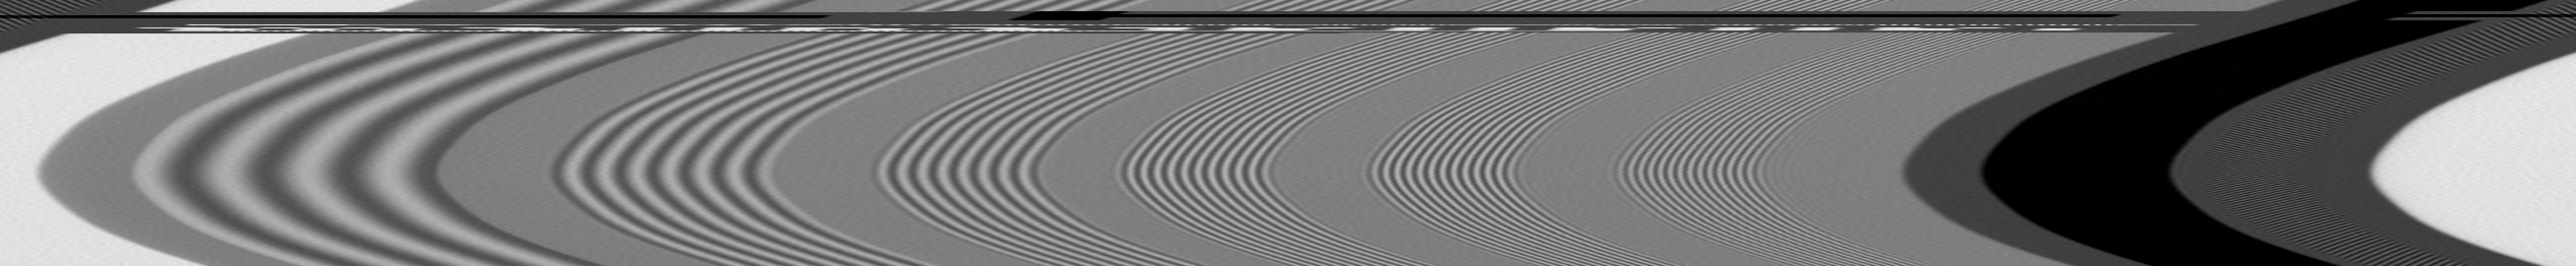

In [11]:
reduced = (demod[0]['demod'] - rfn.SysParams['ire0']) / rfn.SysParams['hz_ire']
reduced += 40
out_scale = 65534.0 / 160
foo = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

draw_raw_bwimage(foo, rfn.linelen, 262, hscale=2, vscale=2)

In [33]:
f = FieldNTSC(rfn, demod, 0)



def Xdetermine_field(self, peaknum):
    if peaknum < 11:
        return None

    ds = self.data[0]['demod_sync']    

    # Determine first/second field
    # should this rely on what comes *after* the vsync too?
    line0 = None
    for i in range(peaknum - 1, peaknum - 10, -1):
        peak = ds[self.peaklist[i]]
        prevpeak = ds[self.peaklist[i + 1]]

        if peak > .5 and line0 is None:
            line0 = i

    print(line0, (self.peaklist[line0 + 1] - self.peaklist[line0]))
    return line0, (self.peaklist[line0 + 1] - self.peaklist[line0]) < (self.inlinelen * .75)     


Xdetermine_field(f, 18)

[(156, 151, True), (475, 469, False)]
audio  262 315
a  263.2377622377623
17 2560


(17, False)

In [ ]:
rfn = RFDecode(system='NTSC')

In [ ]:
bytes_per_frame = int(rfn.freq_hz / rfn.SysParams['FPS'])
bytes_per_frame

In [73]:
#infile = open('/mnt3/dd/War of the worlds_CAV_NTSC_side1_2018-10-03_06-24-34.lds', 'rb')
infile = open('/mnt3/erica-first2000.lds', 'rb')
loader = load_packed_data_4_40

nextsample = 1024*1024*30000
nextsample = 1024*1024*1000 + (bytes_per_frame * 478)
#nextsample = 2059514098
#nextsample = 70937831028

outfile = open('tmpntscb.tbc', 'wb')
outfile_audio = open('tmpntscb.pcm', 'wb')

framer_ntsc = Framer(rfn)
ca = []
for f in range(0,1):
    combined, audio, nextsample, fields = framer_ntsc.readframe(infile, nextsample, f == 0)
    
    print('frame ', framer_ntsc.vbi['framenr'])
    
    ca.append(audio)
    
    outfile.write(combined)
    print(len(audio)//2)
    outfile_audio.write(audio)

#draw_raw_bwimage(combined, outwidth, 610, hscale=2, vscale=2)

outfile.close()
outfile_audio.close()

draw_raw_bwimage(combined, 844, 504, hscale=2, vscale=2)

starting at  1813376000
[(177, 170, False)]
too short
invalid  1813376000 1813782603
[(17, 10, False), (287, 281, True)]
audio  263 266
a  264.22115384615387
False None


NameError: name 'bottomfieldfirst' is not defined

In [21]:
rf_pal = RFDecode(system='PAL')
framer_pal = Framer(rf_pal)
bytes_per_frame = int(rf_pal.freq_hz / rf_pal.SysParams['FPS'])

infile_pal = open('/home/cpage/ddsftp/Domesday/Simon/LDV4300D_2 Captures/AIV/Domesday_DiscSet2/Domesday Community North_CAV_PAL_side1_Disc set 2_2018-10-02_15-11-01.lds', 'rb')
infile_pal = open('/mnt3/pal/DVL909E_Jason_CAV_S4_LeadIn+ChapterJumpsEvery10-15 seconds.lds', 'rb')
loader = load_packed_data_4_40

nextsample = 5400003375 + (bytes_per_frame * 0)
nextsample = 1024 * 1024 * 1000
demod = rf_pal.demod(infile_pal, nextsample, 650*rf_pal.inlinelen)

f, ns = framer_pal.readfield(infile_pal, nextsample)

#combined, audio, nextsample, fields = framer_pal.readframe(infile_pal, nextsample, f == 0)


PAL
starting at  1048576000
[(156, 151, True)]
too short
invalid  1048576000 1048937206
[(15, 10, True), (334, 328, False)]
audio  312 317
a  313.17447916666663


In [42]:
def Xdetermine_field(self, peaknum):
    if peaknum < 11:
        return None

    ds = self.data[0]['demod_sync']    

    # Determine first/second field
    # should this rely on what comes *after* the vsync too?
    line0 = None
    for i in range(peaknum - 1, peaknum - 10, -1):
        peak = ds[self.peaklist[i]]
        prevpeak = ds[self.peaklist[i + 1]]

        print(i, self.peaklist[i] - self.peaklist[i - 1], peak, line0)
        if peak > .535 and line0 is None:
            line0 = i - 0

    vsgap = self.peaklist[peaknum] - self.peaklist[line0]
    print(vsgap, vsgap / self.rf.inlinelen)
            
    print(line0, (self.peaklist[line0 + 1] - self.peaklist[line0]), (self.peaklist[peaknum] - self.peaklist[line0]))
            
    return line0, (self.peaklist[line0 + 1] - self.peaklist[line0]) < (self.inlinelen * .75)

def Xdetermine_field(self, peaknum):
    if peaknum < 11:
        return None

    ds = self.data[0]['demod_sync']    

    # Determine first/second field
    # should this rely on what comes *after* the vsync too?
    line0 = None
    for i in range(peaknum - 10, peaknum + 1, 1):
        peak = ds[self.peaklist[i]]
        nextpeak = ds[self.peaklist[i + 1]]

        nextgap = self.peaklist[i + 1] - self.peaklist[i]
        
        if line0 is None and nextpeak < .525 and inrange(nextgap, self.rf.inlinelen * .4, self.rf.inlinelen * .6):
            line0 = i

    vsgap = self.peaklist[peaknum] - self.peaklist[line0]
            
    return line0, ds[self.peaklist[line0]] > .6

def Xdetermine_vsyncs(self):
    # find vsyncs from the peaklist
    ds = self.data[0]['demod_sync']
    vsyncs = []

    prevpeak = 1.0
    for i, p in enumerate(self.peaklist):
        peak = ds[p]
        # XXX: write better detection code here
        if peak > .9 and prevpeak < .55:
            #print(i, peak, prevpeak, p)
            vsyncs.append((i, *Xdetermine_field(self, i)))

        prevpeak = peak

    print(vsyncs)
    return vsyncs

Xdetermine_vsyncs(f)

[(15, 10, False), (334, 328, True)]


[(15, 10, False), (334, 328, True)]

(670720,)
uint8 (262, 2560) (262, 2560)


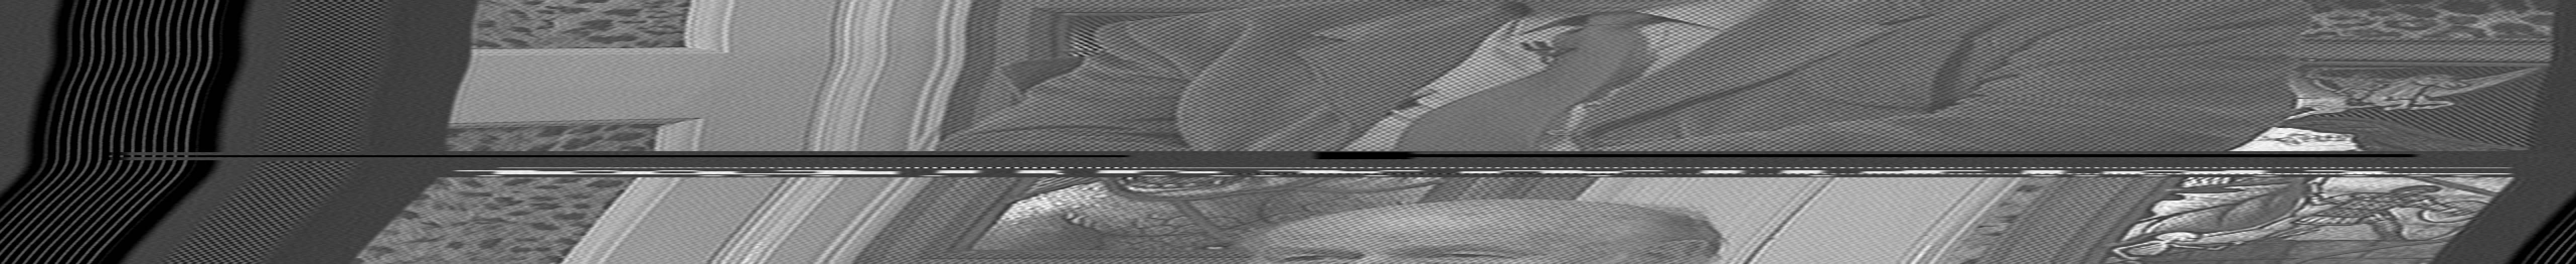

In [215]:
reduced = (demod[0]['demod'] - rf_pal.SysParams['ire0']) / rf_pal.SysParams['hz_ire']
reduced += 40
out_scale = 65534.0 / 160
foo = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

draw_raw_bwimage(foo, rf_pal.linelen, 262, hscale=2, vscale=2)

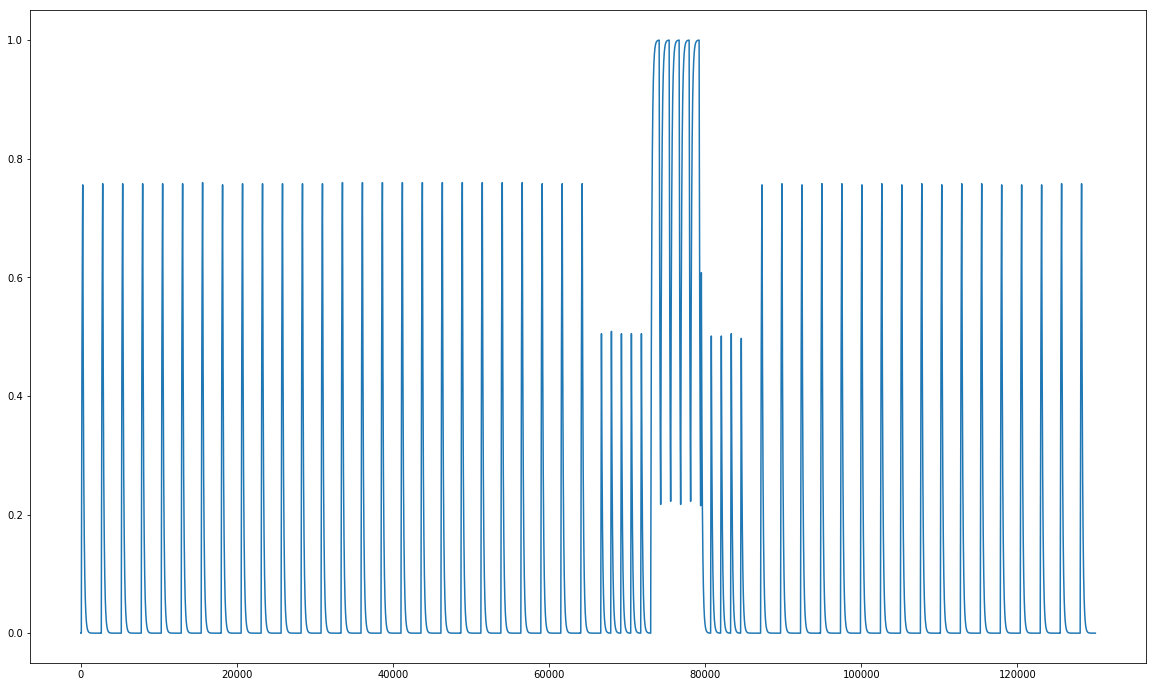

In [216]:
plt.plot(demod[0]['demod_sync'][320000:450000])

PAL
starting at  32000000
[(177, 172, True)]
too short
invalid  32000000 32415452
[(15, 10, True), (334, 328, False)]
audio  312 317
a  313.17447916666663
True None
starting at  33214414
[(16, 10, False), (335, 330, True)]
cav frame  51167
cav frame  51167
audio  313 318
a  314.15104166666663
False None
starting at  34015478
[(15, 10, True), (334, 328, False)]
audio  312 317
a  313.17447916666663
True None
(641720,)
uint8 (610, 1052) (610, 1052)


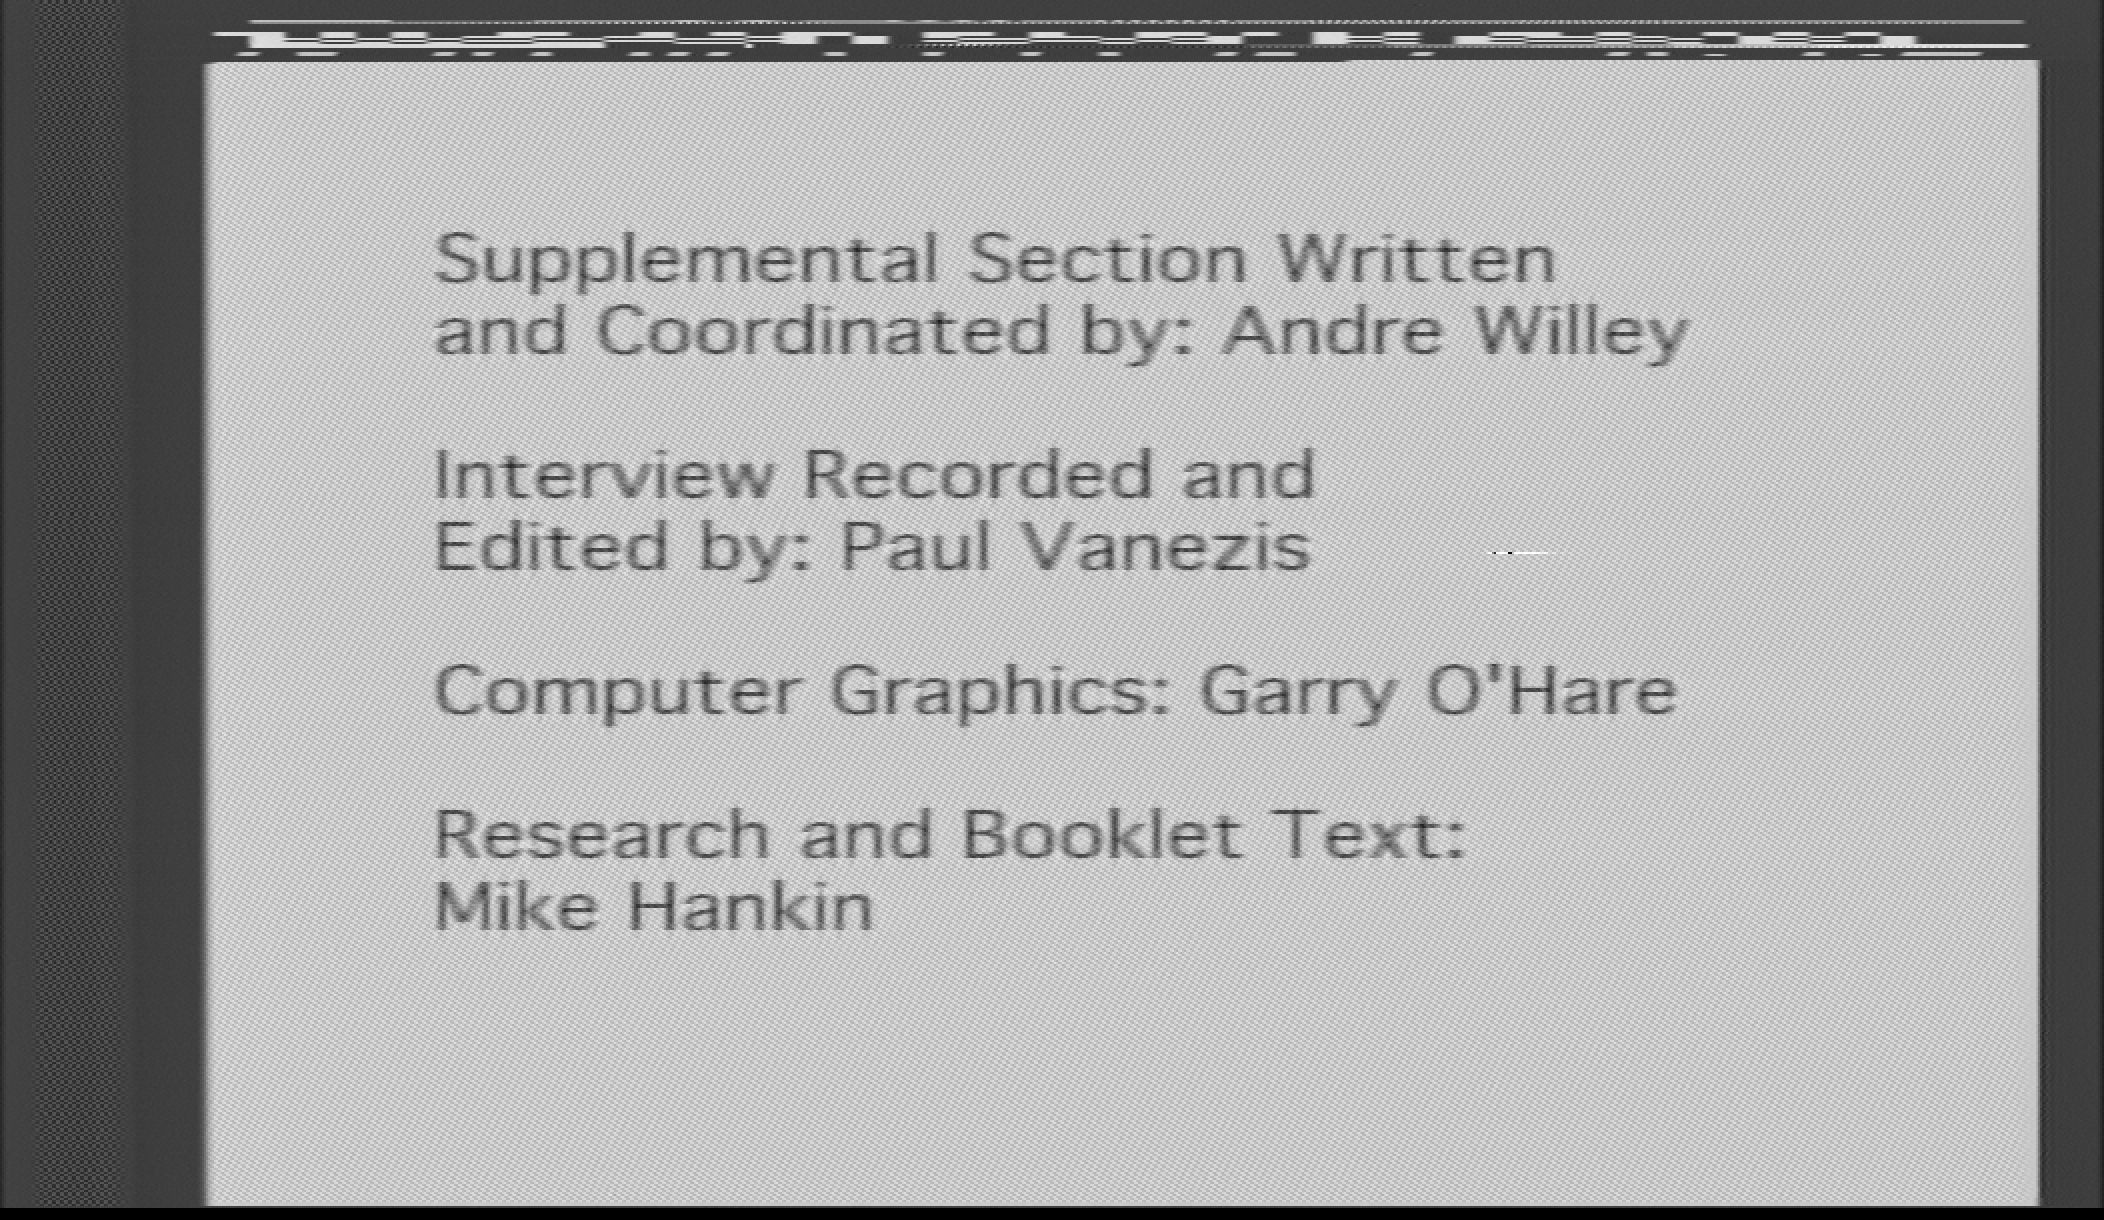

In [41]:
rf_pal = RFDecode(system='PAL')
bytes_per_frame = int(rf_pal.freq_hz / rf_pal.SysParams['FPS'])

infile_pal = open('/home/cpage/ddsftp/Domesday/Simon/LDV4300D_2 Captures/AIV/Domesday_DiscSet2/Domesday Community North_CAV_PAL_side1_Disc set 2_2018-10-02_15-11-01.lds', 'rb')
infile_pal = open('/mnt3/pal/DVL909E_Jason_CAV_s4_TestCards.lds', 'rb')
#infile_pal = open('/mnt3/palclv.r30', 'rb')
loader = load_packed_data_4_40

nextsample = 5400003375 + (bytes_per_frame * 0)
nextsample = bytes_per_frame * 1120
nextsample = bytes_per_frame * 20

framer_pal = Framer(rf_pal)

outfile = open('tmppal.tbc', 'wb')
outfile_audio = open('tmppal.pcm', 'wb')

allaudio = []

for f in range(0,1):
    combined, audio, nextsample, fields = framer_pal.readframe(infile_pal, nextsample, f == 0)
    
    outfile.write(combined)
    outfile_audio.write(audio)
    allaudio.append(audio)

#draw_raw_bwimage(combined, outwidth, 610, hscale=2, vscale=2)

outfile.close()
outfile_audio.close()

draw_raw_bwimage(combined, 1052, 610, hscale=2, vscale=2)

In [28]:
fields[1].vbi

{'clvframe': None,
 'framenr': None,
 'isclv': True,
 'minutes': 1,
 'seconds': None,
 'status': None,
 'statuscode': None}

0 0.040293411797601486
1 0.05610153201437207
2 2559.657672624522 40.00534958059649
2 0.07892851767351239
3 2560.169697419584 39.9973486535716
3 0.022909516698442545
4 2559.4795305545267 40.00813398879358
4 0.06459755105708531
5 2560.3777386407164 39.994098704499486
5 0.08451189798358971
6 2560.2928593315955 39.99542459636165
6 0.03445116737230691
7 2559.89672332778 40.0016137631066
7 0.0766810998723102
8 2560.6782556870967 39.989405061950436
8 0.03182387305517609
9 2560.792383094762 39.98762284517882
9 0.005956270169285016
10 2560.957134163589 39.98505036807027
10 -0.022311613943676978
11 2560.4872361470625 39.99238838389531
11 -0.04641737119363665
12 2561.310793785735 39.97952932867163
12 -0.05887424433013688
13 2561.483340447623 39.97683622728753
13 -0.08441136520503711
14 2560.6484015159294 39.9898712917315
14 -0.012906093884576642
15 2560.485707272106 39.99241226349006
15 0.07832993347587625
16 2560.386388316052 39.993963593654215
16 0.05912721358900086
17 2561.1367442251503 39.982

10 0.04072937818534417
11 2558.8600852896125 40.01781910182492
11 0.05319376571023593
12 2559.256246260127 40.01162452944615
12 -0.015313827150337467
13 2559.4527753974544 40.00855221253239
13 0.006420423780133966
14 2558.8960633686656 40.01725645128206
14 0.0182273648180713
15 2559.0240850122427 40.01525448695029
15 0.04026094040933703
16 2558.567057340748 40.022402268568904
16 0.0554477233480446
17 2559.051661090096 40.014823286678
17 -0.03828832677326588
18 2559.242543403365 40.01183876219294
18 -0.02231771369518265
19 2559.1884690450534 40.01268419211422
19 -0.017142495068886987
20 2559.0150344332797 40.01539601062858
20 -0.019994100289590477
21 2558.972552632331 40.016060310871445
21 0.06707570020367237
22 2559.0520295511524 40.014817525207
22 -0.022089826212016384
23 2558.9293436637963 40.01673600467094
23 -0.012942551436836425
24 2558.462916114455 40.02403136470517
24 0.06380171520585343
25 2558.7699837174005 40.01922824310785
25 0.06495059278270521
26 2559.129894870057 40.01360

0 0.040293411797601486
1 -0.03764846798562793
2 2560.279416548041 39.99563459290834
2 -0.01797025865083235
3 2560.387722888114 39.993942747269905
3 0.02180438048984179
4 2559.7077607975516 40.0045667588609
4 0.06415745841836706
5 2560.486295651732 39.992403073548054
5 -0.009800038980005255
6 2560.5288657654746 39.99173817920906
6 0.03316383050959715
7 2560.128815431046 39.99798736016298
7 -0.018154640851361314
8 2560.9448077612615 39.98524282509489
8 0.03130671411554298
9 2560.6571807270448 39.98973418648945
9 0.0062991367343863125
10 2560.8045434933083 39.98743295742188
10 -0.02192299209301174
11 2560.3565994585297 39.99442890949479
11 0.047756218061838496
12 2560.7420979863164 39.98840807925328
12 0.03614368074086727
13 2560.8403802025787 39.9868733684602
13 0.011524191281423679
14 2560.518106661708 39.991906221473535
14 -0.012371160011526605
15 2560.969446437375 39.984858133489666
15 -0.01733001791707167
16 2560.794160217418 39.98759509483807
16 0.057305118896307405
17 2560.59814259

295 2559.814868019079 40.002892896408
295 -0.01894772520373067
296 2560.4632988240337 39.992762265731415
296 -0.00890128387083955
297 2560.471059646574 39.99264104712609
297 0.0025244197074565378
298 2559.737447773223 40.00410279932429
298 0.016940255642980517
299 2559.9079308534274 40.001438632154894
299 0.02479952318974199
300 2560.0608520976966 39.999049208574135
300 0.037047616240039716
301 2560.130395738175 39.997962670364096
301 -0.06789682758787485
302 2560.3967976840213 39.993800997027016
302 -0.05394954915466332
303 2560.051421416574 39.99919655650439
303 0.030476801559040645
304 2559.7760573201813 40.00349941049223
304 0.031998578887091345
305 2559.6015090438304 40.00622739054906
305 0.02905649779915609
306 2559.5843570892466 40.00649547508918
306 0.005376932799727729
307 2559.6674172255443 40.0051972810564
307 -0.02228562506232734
308 2559.976672551362 40.00036449470635
308 0.04057453464527061
309 2559.4787958944216 40.008145472530025
309 0.03451784936445357
310 2559.8164862

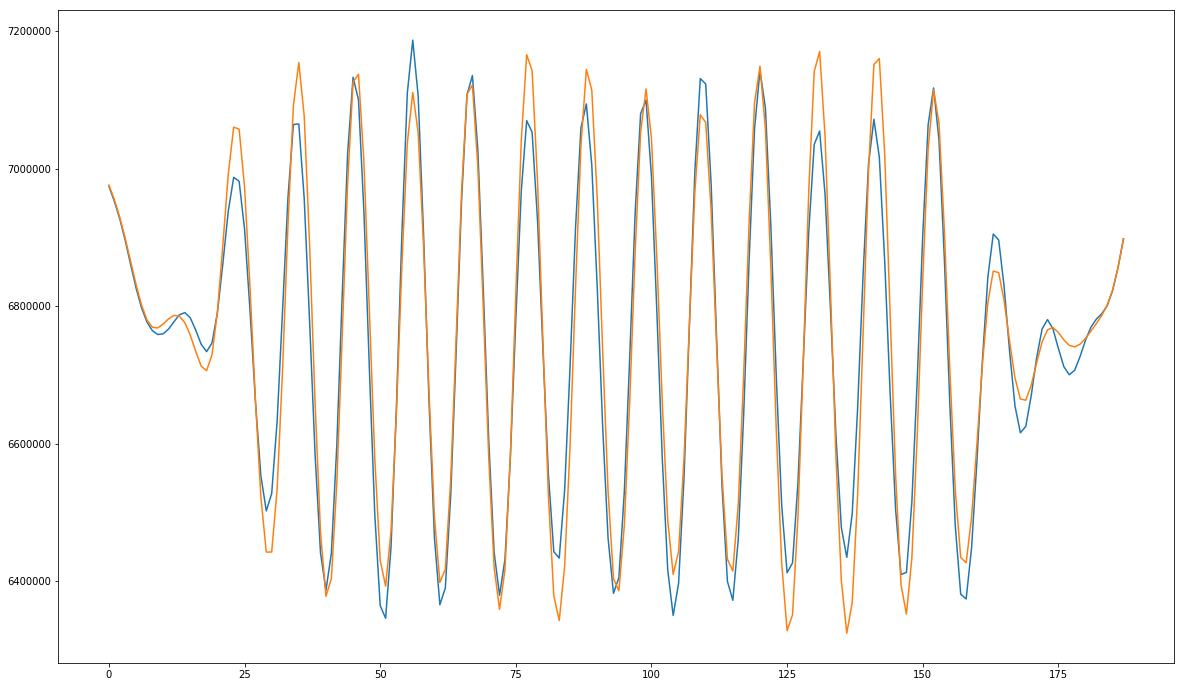

In [175]:
self = fields[1]
def Xrefine_linelocs_pilot(self, linelocs = None):
    if linelocs is None:
        linelocs = self.linelocs[1].copy()
    else:
        linelocs = linelocs.copy()

    pilots = []
        
    for l in range(len(linelocs)):
        pilot = self.data[0]['demod'][int(linelocs[l]-self.usectoinpx(4.7)):int(linelocs[l])].copy()
        pilot -= self.data[0]['demod_05'][int(linelocs[l]-self.usectoinpx(4.7))+32:int(linelocs[l])+32]
        pilot = np.flip(pilot)
        
        pilots.append(pilot)

        adjfreq = self.rf.freq
        if l > 1:
            adjfreq /= (linelocs[l] - linelocs[l - 1]) / self.rf.inlinelen
            print(l, (linelocs[l] - linelocs[l - 1]), adjfreq)

        i = 0

        offsets = []

        while i < len(pilot):
            if inrange(pilot[i], -300000, -100000):
                zc = calczc(pilot, i, 0)

                if zc is not None:
                    zcp = zc / (adjfreq / 3.75)
                    #print(i, pilot[i], zc, zcp, np.round(zcp) - zcp)

                    offsets.append(np.round(zcp) - zcp)

                    i = np.int(zc + 1)

            i += 1

        if len(offsets) >= 3:
            offsetmedian = np.median(offsets[1:-1])
            print(l, offsetmedian)
            linelocs[l] += offsetmedian * (self.rf.freq / 3.75) * .5

    return linelocs, pilots

f0a, p0a = Xrefine_linelocs_pilot(fields[0])
f1a, p1a = Xrefine_linelocs_pilot(fields[1]) 
f0b, p0b = Xrefine_linelocs_pilot(fields[0], f0a)
f1b, p1b = Xrefine_linelocs_pilot(fields[1], f1a) 

plt.plot(fields[0].data[0]['demod'][int(f0b[21]-188):int(f0b[21]+0)])
plt.plot(fields[1].data[0]['demod'][int(f1b[21]-188):int(f1b[21]+0)])

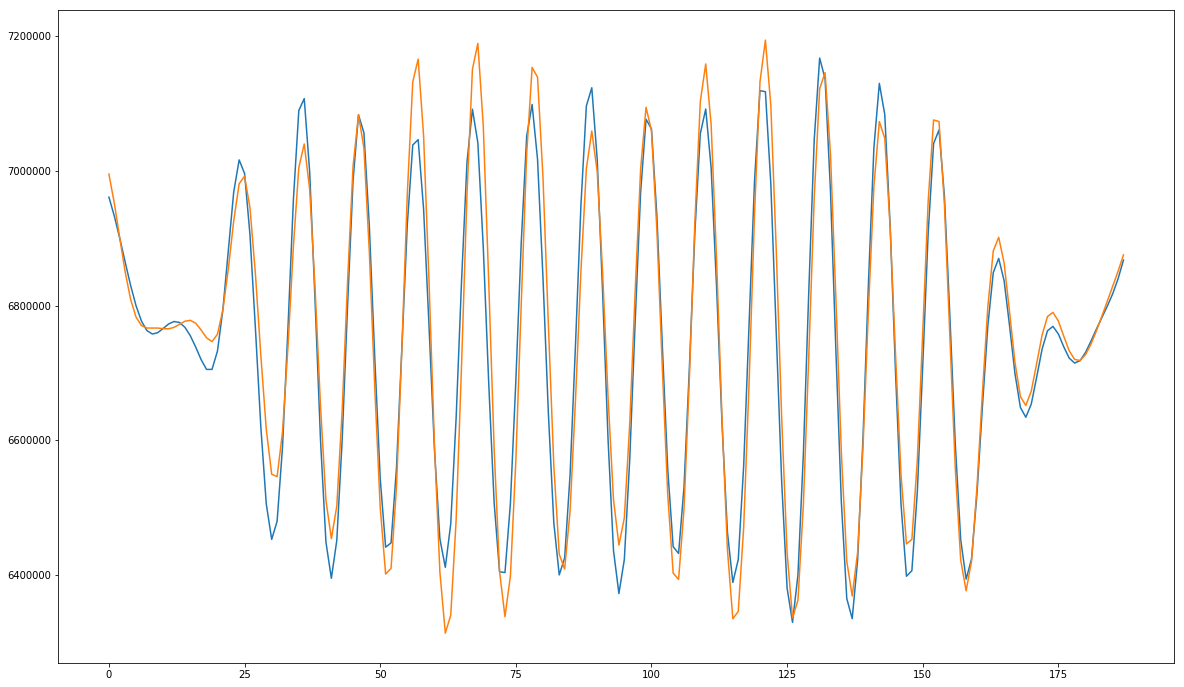

In [176]:
l = 32
plt.plot(fields[0].data[0]['demod'][int(f0a[l]-188):int(f0a[l]+0)])
plt.plot(fields[1].data[0]['demod'][int(f1a[l]-188):int(f1a[l]+0)])

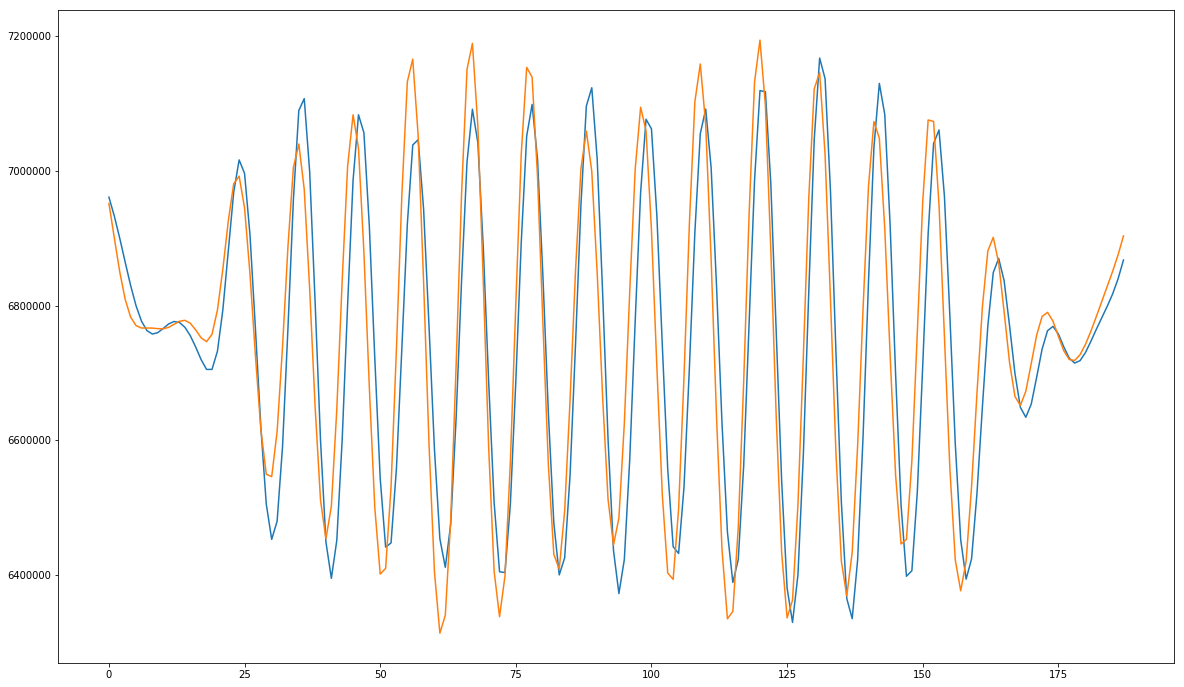

In [177]:
l = 32
plt.plot(fields[0].data[0]['demod'][int(f0b[l]-188):int(f0b[l]+0)])
plt.plot(fields[1].data[0]['demod'][int(f1b[l]-188):int(f1b[l]+0)])

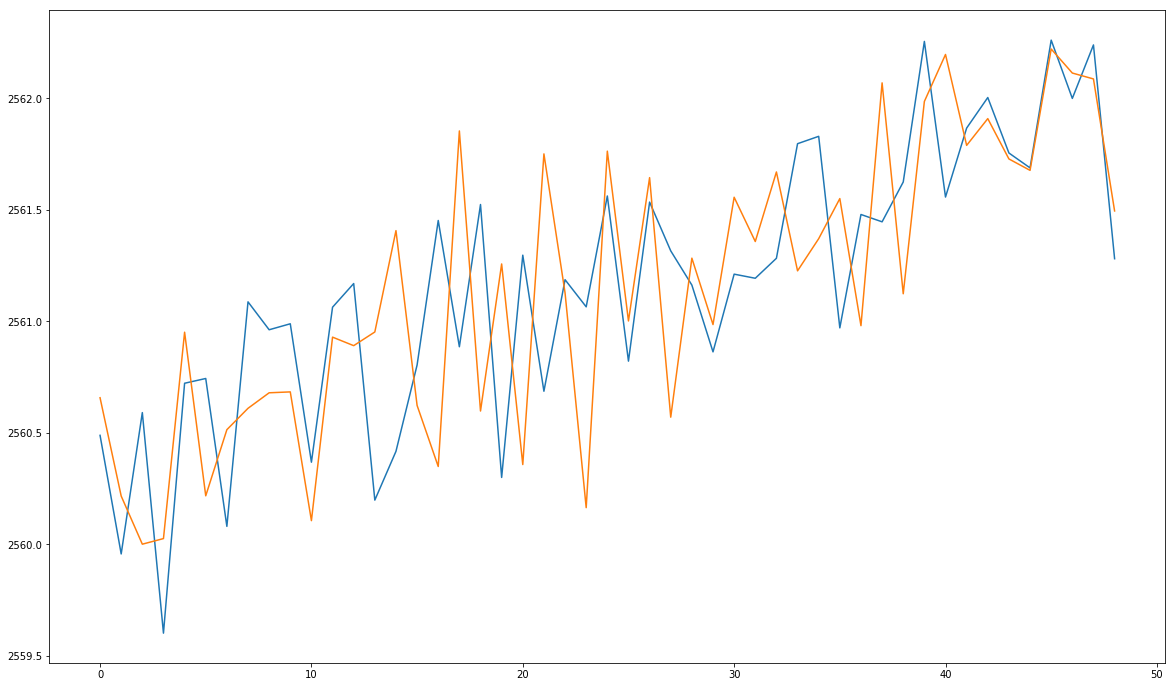

In [172]:
plt.plot(np.diff(fields[0].linelocs[1][0:50]))
plt.plot(np.diff(f0a[0:50]))
#plt.plot(np.diff(f0b))

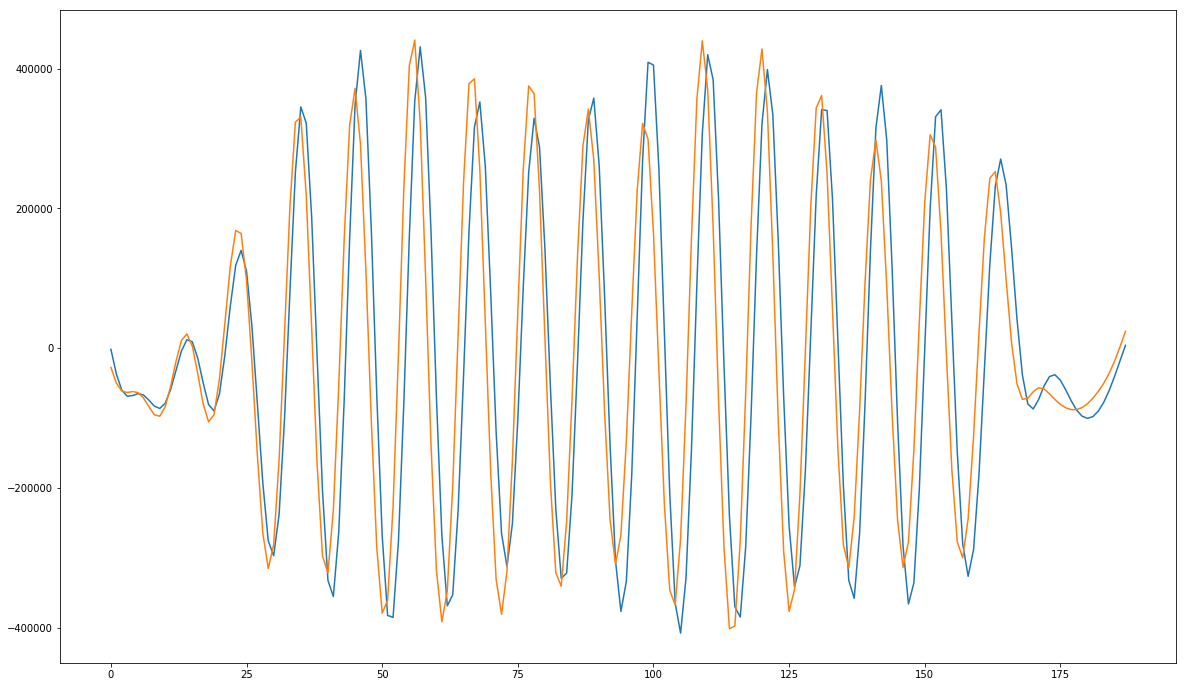

In [158]:
l = 75
plt.plot(p0a[l])
plt.plot(p1a[l])

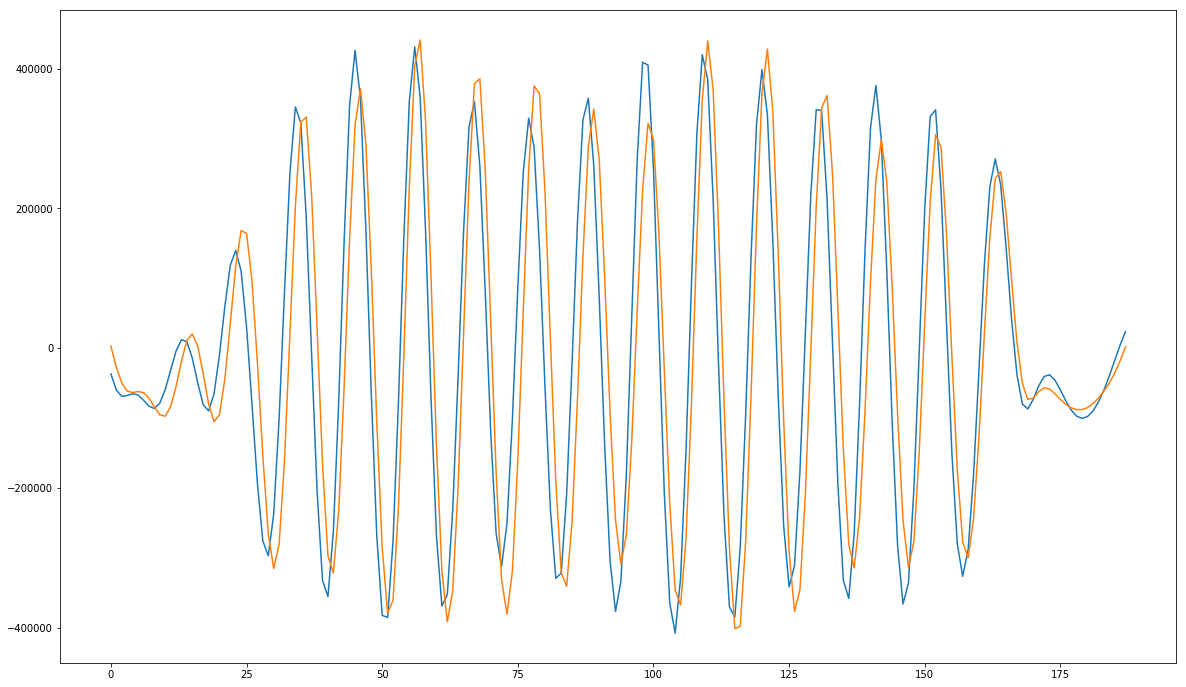

In [159]:
l = 75
plt.plot(p0b[l])
plt.plot(p1b[l])

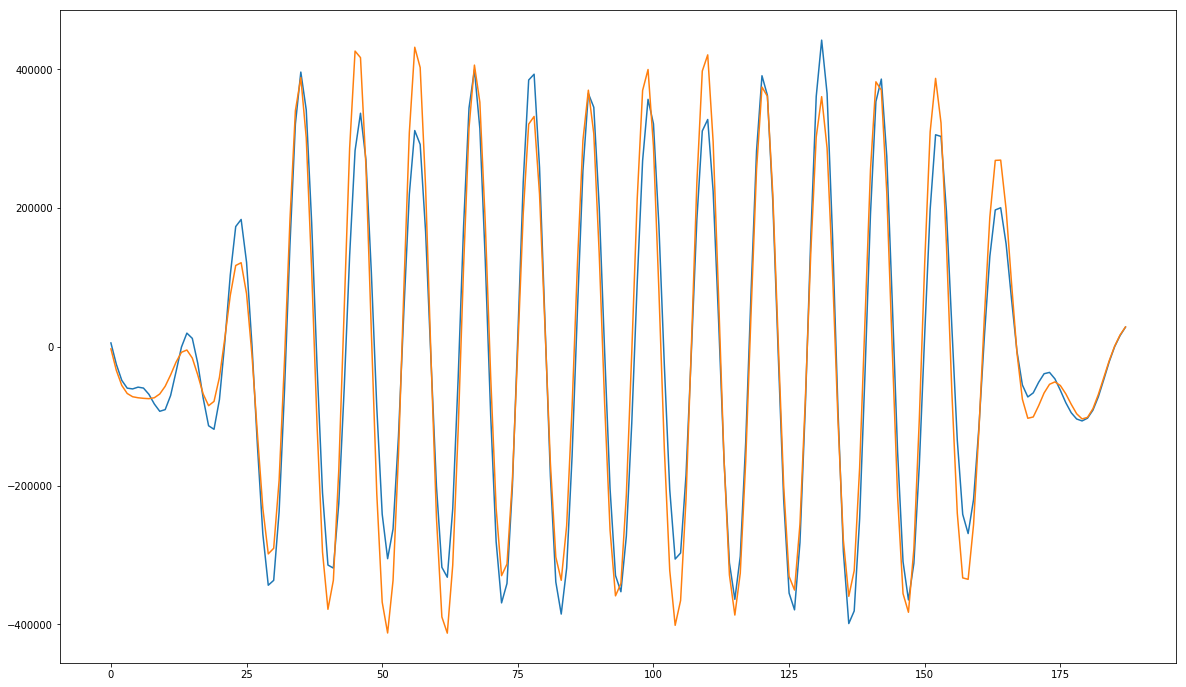

In [146]:
plt.plot(p0b[21])
plt.plot(p1b[21])

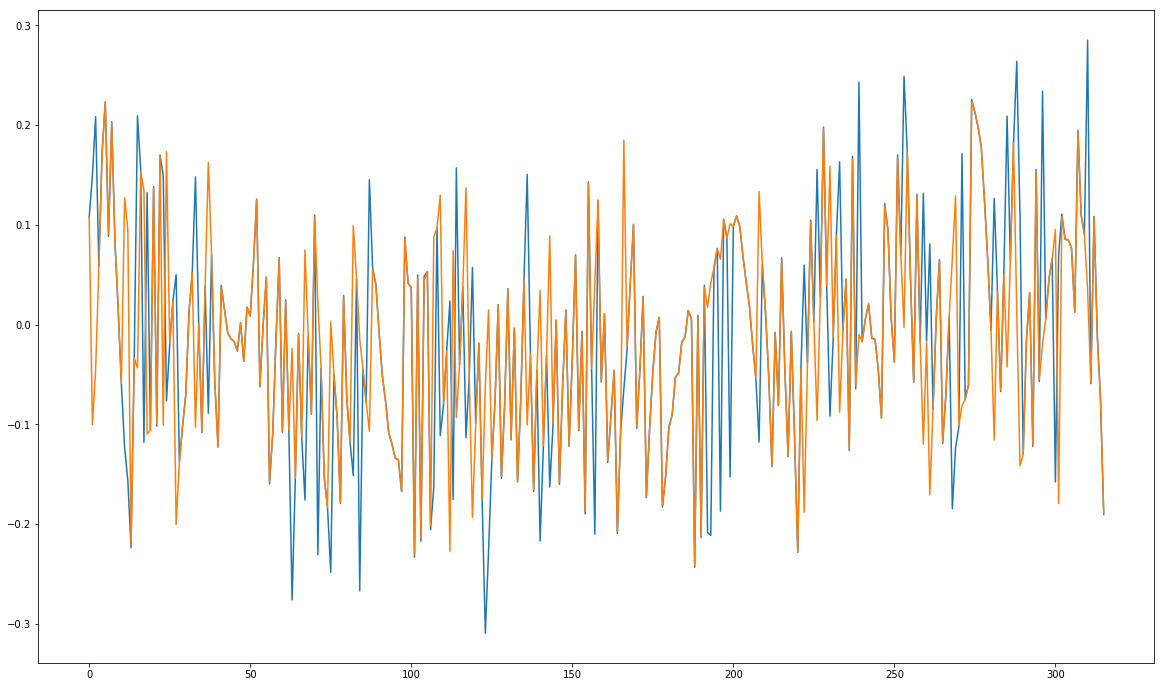

In [132]:
plt.plot(np.array(f0a) - np.array(fields[0].linelocs[1]))
plt.plot(np.array(f0b) - np.array(f0a))

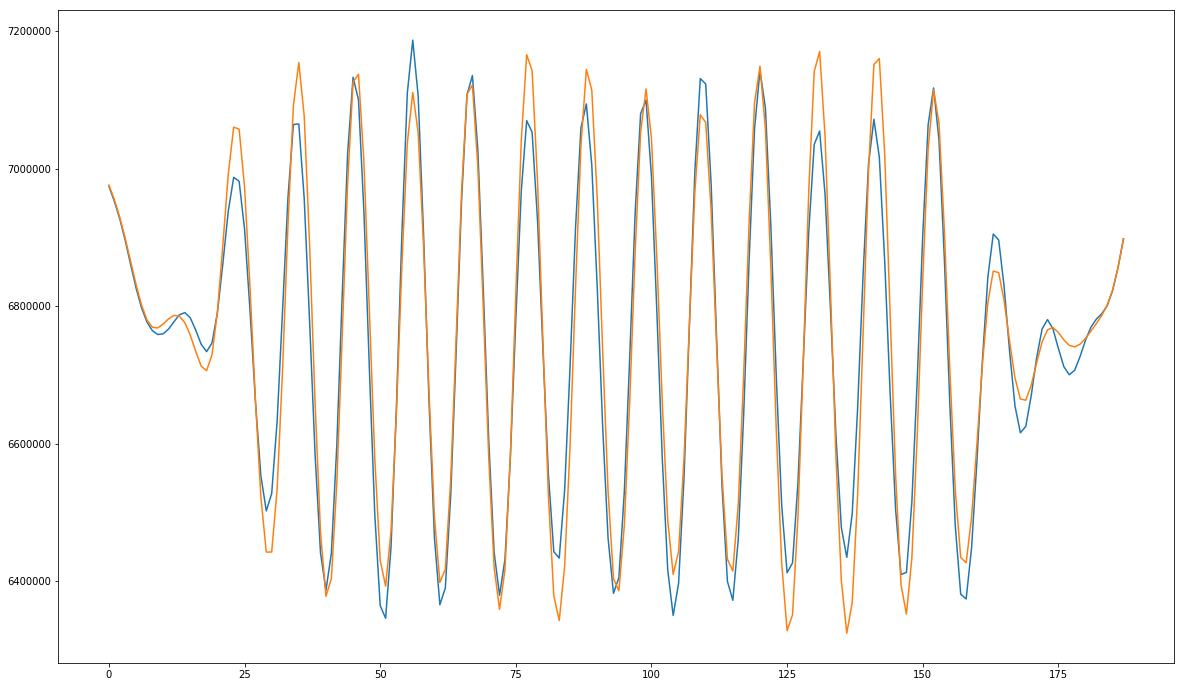

In [124]:
plt.plot(fields[0].data[0]['demod'][int(f0a[21]-188):int(f0a[21]+0)])
plt.plot(fields[1].data[0]['demod'][int(f1a[21]-188):int(f1a[21]+0)])

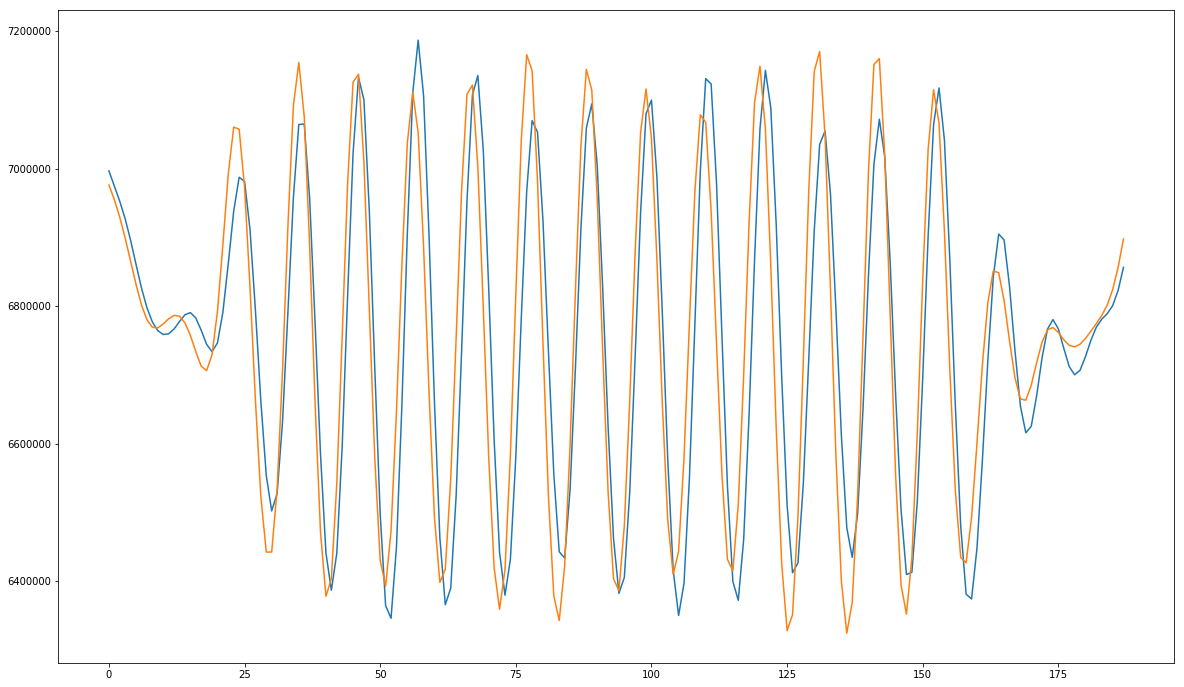

In [125]:
plt.plot(fields[0].data[0]['demod'][int(f0b[21]-188):int(f0b[21]+0)])
plt.plot(fields[1].data[0]['demod'][int(f1b[21]-188):int(f1b[21]+0)])

6 -101734.28341853339 11.683139964591478 1.095294371680451 -0.09529437168045107
26 -103350.5757324826 31.40826238411001 2.9445245985103137 0.05547540148968633
38 -235256.7270475896 42.21771985662785 3.957911236558861 0.04208876344113888
48 -115068.5018983176 53.1725202905119 4.98492377723549 0.015076222764509595
59 -133905.11801831797 63.87512142180464 5.9882926332941855 0.011707366705814515
70 -160861.89727010485 74.17768151204992 6.95415764175468 0.045842358245320014
80 -140932.19747033902 84.74609804691563 7.944946691898341 0.05505330810165887
91 -221202.78513283283 95.57477675663739 8.960135320934755 0.0398646790652446
102 -273726.5918708192 106.41064026258314 9.97599752461717 0.024002475382829402
113 -268265.71488700435 117.12538236656403 10.980504596865378 0.019495403134621725
123 -117825.20974750165 127.59184267390214 11.961735250678325 0.038264749321674785
134 -249430.64728253428 138.04439089319877 12.941661646237385 0.05833835376261476
144 -151394.1318446938 148.89896379168044

133 -115472.6288713729 138.0035164355948 12.940240655577208 0.05975934442279218
144 -165873.99634462036 148.9688048369632 13.968428012221391 0.0315719877786087
155 -128631.8788474435 160.04196829622362 15.00673054017361 -0.006730540173609967
178 -103353.0243471954 184.41307404789688 17.29194747967351 -0.2919474796735102
20 0.02466129040346142 6.576344107589711
18 -113781.80405554734 20.90992894417235 1.961248297856057 0.03875170214394297
27 -142291.21914439555 32.295104671614816 3.0291216787678477 -0.02912167876784766
39 -210592.65986350365 43.31064519568469 4.062325099041431 -0.062325099041430576
50 -241191.7901936937 53.710095081275746 5.037742253313454 -0.03774225331345438
60 -201020.2170693362 64.20902345627425 6.022489999695312 -0.022489999695311624
71 -280787.00084606 74.92911157073955 7.027981439838233 -0.02798143983823298
81 -185986.26982519217 85.73898995478412 8.041894764811397 -0.04189476481139742
92 -204501.79172162618 96.54526559559335 9.055470170222195 -0.0554701702221951

49 -258668.31040434167 52.71000853206218 4.946474148885128 0.0535258511148724
59 -216993.85346647166 63.449032461942046 5.954258168140176 0.04574183185982417
70 -267449.17519077193 74.38258396598748 6.980297271081466 0.019702728918534085
81 -267970.5703777252 85.24797506780278 7.999939985993264 6.0014006735720216e-05
91 -111664.98911114316 95.73300287100922 8.983888204240182 0.016111795759817582
102 -212113.65910623223 106.08340039343804 9.955202290524884 0.044797709475115965
112 -127348.3286423618 116.90039552553714 10.970303374354117 0.029696625645883046
123 -165265.65859166626 127.79730142302381 11.992903537508425 0.007096462491574584
134 -178437.06316543464 138.51054495408889 12.99826824248452 0.0017317575154791598
145 -229092.41378250718 149.03738403886922 13.98614016382307 0.013859836176930429
155 -114557.545601869 159.84229995757627 15.00010769600914 -0.00010769600913995703
51 0.02601339821670607 6.9369061911216185
18 -114143.07729771733 20.187641696365205 1.894094478578805 0.10

18 -106046.24766048789 21.0770113488782 1.978333510321799 0.021666489678201062
28 -228430.15847297292 32.454529871028114 3.046251811645583 -0.04625181164558301
39 -220554.83154001646 42.99889274970631 4.035968336564214 -0.035968336564214276
49 -156301.90667222906 53.58471297907832 5.029576137374345 -0.02957613737434528
60 -253502.43083909992 64.25155590007475 6.030788901871398 -0.030788901871398267
71 -283409.5877093794 75.14776460831695 7.05353043131139 -0.05353043131138957
81 -118424.61592414416 85.942611011889 8.066757877341113 -0.0667578773411126
92 -164794.77641402092 96.20735674095019 9.030228936619881 -0.030228936619881352
102 -101194.271113744 106.87837692178053 10.031833787688125 -0.03183378768812517
113 -186650.86760201864 117.59100565341429 11.037344106614587 -0.037344106614586536
124 -244738.400643182 128.4265837909319 12.054394720590855 -0.05439472059085482
135 -240492.8600891279 139.20212809515527 13.06581043015904 -0.06581043015903987
145 -113632.16119648702 149.62600295

27 -194880.31850590184 31.80562008923991 2.9849831268481 0.015016873151899812
38 -175073.21119944192 42.56667722074434 3.994917027663828 0.0050829723361718315
49 -244822.41644255817 53.481004453807685 5.019235451268925 -0.019235451268924564
60 -251022.4734236747 64.12071119095138 6.017780519589426 -0.017780519589425836
70 -111806.47573067807 74.60660853813579 7.001890452468736 -0.0018904524687357593
81 -237078.96673417185 85.0890987341519 7.985680621459794 0.014319378540205818
91 -129741.65093551762 95.93482434330079 9.003560727268082 -0.003560727268082431
102 -174744.6679298794 106.77142817616011 10.020584747006211 -0.020584747006211046
113 -215846.7439999897 117.41136908599685 11.019151792623038 -0.019151792623038233
124 -222131.65933026467 128.06577520354267 12.019076409663304 -0.01907640966330426
134 -159239.84653975908 138.52387287252122 13.000577320296124 -0.0005773202961236734
145 -250043.16377238464 149.33299841933126 14.015022480701163 -0.015022480701162522
156 -233967.2667874

71 -255552.6568211196 74.67403251535988 7.010198498838195 -0.01019849883819468
81 -232484.26251300797 85.19511810568356 7.997889881331358 0.0021101186686420803
92 -259954.57561947685 96.04012271949432 9.01598991561023 -0.015989915610230554
102 -132820.35883474816 106.96635582906656 10.04171546387126 -0.04171546387125957
113 -151145.46463950723 117.68538253693983 11.04798902919778 -0.04798902919777959
124 -194595.414239157 128.1454604943478 12.029953178243419 -0.029953178243419032
134 -143543.88429079298 138.4839230154166 13.000500395317628 -0.0005003953176281328
145 -248158.58746800292 149.45022936856705 14.029987912532428 -0.029987912532428496
156 -212508.54967917223 160.61911807069237 15.078493318976426 -0.07849331897642564
129 -0.02451338701327089 -6.536903203538904
5 -101300.66887065303 11.880541533729138 1.1151857516540713 -0.1151857516540713
18 -107416.6220245352 20.313230707117786 1.9067334086015555 0.09326659139844451
27 -185499.5574818058 31.83491908424979 2.988234843253993 0.

123 -164993.47027423885 127.70469451071008 11.989124899499634 0.010875100500365775
134 -207351.4117515618 138.45736685239387 12.99860330749215 0.001396692507849906
145 -236751.75438189972 149.3100919814022 14.017474834260549 -0.017474834260548633
156 -185281.48594390787 160.35743565370876 15.054617467132768 -0.05461746713276838
160 -0.0011920832821701013 -0.3178888752453603
27 -113886.90976107027 32.19186305713392 3.0223334551319923 -0.022333455131992253
39 -253565.07931152172 42.82877210725407 4.020979790832346 -0.020979790832345913
49 -166852.37681134883 53.692340828820825 5.040906072546589 -0.040906072546588845
60 -210075.84828714095 64.60206731850771 6.065165876882872 -0.06516587688287157
71 -204810.1159607498 75.21417704705001 7.061483927974899 -0.061483927974898656
81 -103037.55189823266 85.57755473606431 8.034449768506931 -0.03444976850693138
92 -206999.86030521244 96.40583191058457 9.051062702896953 -0.05106270289695303
103 -211953.507320093 107.24392580903897 10.06859728053307

82 -285244.81674945913 86.09479978681148 8.082949039187369 -0.08294903918736907
92 -140397.7647408722 96.92347664877528 9.099591663989532 -0.09959166398953201
103 -178207.22639555205 107.43191952675576 10.086169348986243 -0.08616934898624251
114 -247621.54816070478 117.97685879099315 11.076173471246987 -0.07617347124698703
124 -170648.6879419908 128.59828935614738 12.07335892488643 -0.07335892488642948
135 -233562.81513684615 139.39945822569948 13.087418981387318 -0.08741898138731763
146 -266858.02629068866 150.3490750102286 14.11541596479557 -0.11541596479557015
157 -192379.42861122545 161.39946691920014 15.152874149081258 -0.15287414908125818
180 -105787.98189911526 186.39814193006796 17.49985697104497 -0.49985697104497007
190 -0.11691030881776222 -31.176082351403256
27 -210702.14744812623 31.447547489454983 2.950973197575768 0.04902680242423196
38 -208429.68479142804 42.162738079416364 3.956464651193734 0.04353534880626597
49 -260152.69317843765 53.174612058490474 4.989796264039735 

145 -235913.97038149275 148.78905792623655 13.961616992090624 0.03838300790937588
155 -174319.15236024 159.86089321551586 15.000542339578645 -0.0005423395786454677
177 -100076.6582633825 186.82152249517574 17.530392216408742 0.46960778359125754
222 0.05683514400021166 15.156038400056444
27 -163278.4160687793 31.81387452144594 2.985177379378014 0.014822620621985916
38 -159705.8726280583 42.37152907199547 3.9758291631568916 0.02417083684310839
49 -265421.44116799906 53.41433058575766 5.012003529835256 -0.012003529835255655
60 -261235.03747708257 64.24946336947053 6.028691807356844 -0.028691807356843846
70 -113235.98567321803 74.79017911422875 7.01775417957732 -0.017754179577320173
81 -192669.1618563095 85.19726479358171 7.994277700291871 0.005722299708128986
91 -127432.03384066839 95.86734777364084 8.995478931744744 0.004521068255256111
102 -183560.74250948895 106.76659493881402 10.018183225991963 -0.018183225991963425
113 -182040.9295954015 117.71818564915937 11.045799049229435 -0.04579

102 -239237.7909841463 105.90032837125736 9.933583832437757 0.06641616756224344
112 -150621.62520801462 116.78422009042745 10.95450654796066 0.04549345203933974
123 -205708.2579302648 127.72768329131223 11.981017143301658 0.018982856698341877
134 -199818.37063509785 138.1179685449824 12.955638952295857 0.044361047704143175
144 -143552.02203759085 148.52924541081535 13.932229800880432 0.06777019911956828
155 -181972.88981170207 159.447089116277 14.95633725536772 0.04366274463228059
251 0.054591812828734036 14.557816754329075
26 -111596.81050078664 31.245239814744775 2.9312232106999416 0.06877678930005837
38 -245397.93271651492 42.22797041530886 3.9615508716208225 0.038449128379177466
49 -263483.2501773909 53.23966572051966 4.994595810919303 0.005404189080697286
59 -120760.36295958888 63.67696790290742 5.973754959496766 0.026245040503233952
70 -195272.8996744575 74.166516010839 6.957815477707702 0.04218452229229808
80 -135181.70887465216 84.89022182006161 7.963843133730923 0.036156866269

49 -244156.0280446941 52.67732378342854 4.938640192593158 0.061359807406842215
59 -217697.16799282003 63.52587929015269 5.955721327492046 0.04427867250795359
70 -235806.77731310297 74.552316537059 6.989479351961176 0.010520648038824021
81 -252086.2424199758 85.24527451230797 7.9919728015408396 0.008027198459160445
92 -259122.4188160291 95.79857147564735 8.981372657194003 0.018627342805997316
102 -196458.89254763722 106.07939971748704 9.94522784044211 0.054772159557890276
112 -151368.08987908997 116.86153771999096 10.95608215643155 0.0439178435684493
123 -151084.480899306 127.95664698595441 11.99627836661445 0.00372163338555076
134 -143475.5351117244 138.732716246082 13.00656372175194 -0.006563721751939866
145 -186938.80186924804 149.02588368553089 13.971575737824503 0.02842426217549665
155 -119183.66347745992 159.78638948449614 14.980401976793752 0.019598023206247817
176 -101062.74142882694 185.61864903463749 17.402245497249133 -0.40224549724913317
284 0.002448938271769041 0.6530502058

49 -219448.59020757023 52.99086497193212 4.967165947660353 0.03283405233964665
59 -170840.07997927442 63.526668148103816 5.954752823165241 0.045247176834759095
70 -247572.46316831 74.18960446968777 6.954256685325191 0.045743314674808744
80 -141389.49380701035 85.10211668560605 7.977154860530436 0.022845139469564124
91 -147890.19334514812 95.74621762807321 8.974893164535981 0.02510683546401893
102 -171888.7540741656 106.19784679182858 9.95458988221133 0.04541011778866988
112 -146728.71328768786 116.65836919020262 10.935120218514829 0.06487978148517115
123 -223321.65031016245 127.31574532081504 11.934102889120897 0.06589711087910288
137 -283758.55384767987 138.2630987049156 12.960266945422127 0.039733054577872906
144 -109283.80435302015 149.16828021928208 13.982477968018335 0.01752203198166491
155 -106161.10068552289 159.9951747400788 14.997350659964338 0.0026493400356617514
5 0.039143520593153305 10.438272158174215
102 -190304.9425586192 106.53419646715713 9.984087029345055 0.0159129706

123 -210328.60955279786 127.58590975178723 11.95376727072827 0.04623272927173083
134 -213015.81386213005 138.4840854204287 12.974838138756693 0.02516186124330666
145 -208194.86814178247 148.88157105175247 13.948998402059942 0.051001597940057763
155 -142765.28716099449 159.64255890457417 14.957215881921291 0.042784118078708744
176 -100765.46935622767 185.98876140797057 17.425641853141578 -0.42564185314157754
35 0.01782246846364354 4.7526582569716105
18 -105238.37170665618 20.67545183879885 1.9374659201582327 0.06253407984176729
27 -158847.17821355723 32.044054332249814 3.002800794705128 -0.0028007947051280624
38 -111293.47355078254 42.31947081785594 3.965694830178382 0.03430516982161791
49 -264259.08790726773 53.07923759179236 4.973976612646252 0.02602338735374765
59 -139214.74370473996 63.831612292242966 5.9815656948737725 0.018434305126227457
70 -202629.61524730455 74.73377160983287 7.003190871370671 -0.003190871370670756
81 -204082.24222797714 85.46919024952173 8.009191026298215 -0.0

144 -131422.8640006464 148.8314532177926 13.943933886629525 0.05606611337047518
155 -153767.0668108035 159.74463517487752 14.96638367403883 0.03361632596116948
65 0.06084523443949932 16.22539585053315
7 -102007.04242047854 12.902498678701331 1.2087261810007268 -0.20872618100072682
27 -105591.8693130808 32.38198568123305 3.033594876495401 -0.03359487649540105
39 -233315.8584354883 42.48073560926829 3.9796615057092724 0.02033849429072765
49 -235781.29496899992 53.26879777081152 4.990303979050187 0.009696020949813366
60 -269590.8408789495 64.25203206289538 6.0192304816989735 -0.019230481698973456
70 -124317.39175622724 75.10166584852048 7.0356410807252905 -0.035641080725290486
81 -128190.25866035279 85.57663144952575 8.016952180405363 -0.016952180405363393
92 -222731.00690282136 95.94101640635805 8.987903913031637 0.01209608696836284
102 -164787.64429934602 106.6221663130043 9.988530679742246 0.01146932025775449
113 -229951.4846878713 117.57062354412975 11.014199213130544 -0.0141992131305

156 -152519.01852532662 160.46974405364605 15.032772309728003 -0.032772309728002824
93 -0.04559026230542941 -12.157403281447843
7 -100723.91127454955 12.291421351272177 1.1512546678072895 -0.15125466780728947
18 -111415.22025498003 20.932481088835583 1.9606045447148828 0.03939545528511723
27 -137073.62648293842 32.270250419122185 3.022537049588602 -0.02253704958860192
42 -198919.11652590148 42.869322898557705 4.015280794811767 -0.015280794811767251
49 -191800.936023104 53.71255131217298 5.030892982248753 -0.030892982248753142
60 -214366.81172397453 64.16904806758778 6.01028261950475 -0.010282619504749846
70 -135293.49332497362 74.54774228660187 6.982385017096695 0.01761498290330543
81 -249104.60079261288 85.23109860024628 7.983023061504684 0.016976938495315785
92 -280230.2854121821 96.03988602144507 8.995409393106918 0.004590606893081883
102 -146871.24650701135 106.9755810555068 10.019682306212896 -0.01968230621289635
113 -153179.4703313522 117.55039144005521 11.01015358438841 -0.01015

124 -240056.205188334 127.89945498445685 11.976250819041228 0.023749180958771987
134 -191526.5407324694 138.23168128072163 12.943739958523475 0.0562600414765253
144 -127689.11784173921 148.78285085399887 13.931730511408636 0.06826948859136373
155 -168933.50879046228 160.1480554072227 14.995945682268115 0.004054317731885249
179 -105279.33594815154 184.65836529167117 17.291042396044208 -0.2910423960442081
119 0.0081641373765665 2.1771033004177336
16 -106908.47696753405 19.727698305877517 1.8467172447745022 0.15328275522549784
26 -163430.3513108911 31.056262645601052 2.90718840569407 0.09281159430593
37 -138165.54429209046 41.87084706198184 3.9195457130262614 0.08045428697373858
48 -168589.55100197997 52.652218121864884 4.928793905587423 0.07120609441257741
59 -231953.83913613297 62.99031640827129 5.896547167405729 0.10345283259427074
69 -168937.54857755732 73.47577376795553 6.878094767396527 0.1219052326034733
80 -240936.3622634299 84.31179173808404 7.892458477741832 0.10754152225816771


37 -130369.6595567353 41.470457358832455 3.8809735025594625 0.1190264974405375
48 -227248.08045042027 52.15031582250772 4.880437949019959 0.1195620509800408
58 -128363.58203453012 63.015491588436596 5.897245139819852 0.10275486018014757
69 -156232.27423405368 73.78241802430811 6.9048577600535825 0.09514223994641746
80 -178957.7974422006 84.29550977135656 7.88871550117352 0.11128449882648006
90 -116089.303144807 94.5849938926942 8.851647134272875 0.1483528657271247
101 -211255.17285533156 105.61920535947401 9.88427337115448 0.1157266288455201
112 -197509.1044792598 116.3388359007411 10.887459849854459 0.11254015014554142
122 -109439.74933225662 127.12251797344115 11.896640530502555 0.10335946949744468
133 -121287.68487882987 137.39072618045503 12.857581077296333 0.1424189227036674
144 -234598.43097026367 147.81631339696457 13.833249789743716 0.1667502102562839
154 -160964.14691246115 159.09729050267052 14.888969355394952 0.11103064460504797
148 0.11772615806703245 31.39364215120865
8 -1

81 -202353.79397155903 85.35233194640104 7.991303201620404 0.008696798379595805
92 -228542.56272224896 95.68129965229554 8.958375931975125 0.04162406802487517
102 -192239.86953462847 106.13429371058976 9.93706090729627 0.06293909270372922
112 -120172.01153031737 116.98985012369725 10.953436684514795 0.04656331548520498
123 -156516.26082992926 127.92019864935303 11.976815040747075 0.02318495925292474
134 -198907.08147543296 138.42408330884157 12.960264762560582 0.03973523743941776
145 -231933.97063536383 149.0545054938664 13.955561843548509 0.044438156451491295
155 -127980.17151006497 159.8908375365304 14.970137696036556 0.029862303963444248
180 0.0320326865924652 8.54204975799072
27 -140681.58543461747 31.91227644272234 2.9884350550479413 0.011564944952058731
38 -145509.31524074543 42.4223231624177 3.972651649677373 0.027348350322626835
49 -216359.32271951437 53.26193807076352 4.98773075985813 0.012269240141869808
60 -249908.08336874098 64.22016478719564 6.013917309705999 -0.0139173097

17 -115452.79028060287 20.3077548931198 1.9014556993808631 0.09854430061913688
27 -188946.3813967593 31.69272291257565 2.9674530211821746 0.03254697881782542
38 -189380.2594745569 42.544519950004855 3.983528477772156 0.016471522227844204
49 -243213.59785459004 53.004443401202465 4.962912026866773 0.03708797313322698
59 -144317.35478486866 63.63583624656586 5.958350598218743 0.041649401781256756
70 -244719.92155558337 74.13930352824958 6.941811243234916 0.05818875676508384
80 -135218.3739701463 85.0577919854955 7.964131150822936 0.035868849177063566
91 -159769.4841155447 95.8502443982145 8.97465005153184 0.02534994846815941
102 -193046.13639874384 106.46976504478486 9.968977005170382 0.0310229948296179
113 -244386.6552218804 116.9626220528851 10.951444189053923 0.04855581094607686
123 -194612.48098962195 127.54660936086607 11.94244408514551 0.05755591485448974
134 -274730.13488227315 138.3711493292793 12.955967407858475 0.04403259214152477
148 -275290.57083969656 149.24384604554527 13.9

19 -102957.17380141933 21.001038289063075 1.9672123962503916 0.03278760374960843
27 -119617.96710478608 32.47677883096264 3.0421696788117365 -0.0421696788117365
39 -196077.886274009 42.859903782813774 4.014779310581022 -0.01477931058102211
49 -177949.65867397003 53.26381120302603 4.989335680831613 0.01066431916838706
60 -289756.862478612 64.10654371080612 6.004997740247043 -0.004997740247042692
70 -152249.26390498225 74.9850026751453 7.024006373638946 -0.02400637363894642
81 -172106.31507346407 85.64337306955186 8.02239883762603 -0.02239883762602979
92 -210823.60368626006 96.22903008469558 9.01398008308714 -0.013980083087140827
102 -122200.2603552416 106.66668834229343 9.991697966819823 0.008302033180177304
113 -227298.97782638762 117.47612800384734 11.00424141376947 -0.0042414137694706255
124 -266101.96675900184 128.19428778313005 12.008234477949442 -0.008234477949441654
134 -142499.8621571837 138.93853787688775 13.014671477964907 -0.014671477964906643
145 -149365.90624539927 149.5108

27 -217623.91614966374 31.375648741205513 2.9392259431639305 0.06077405683606951
38 -253981.64347671997 42.00910018392375 3.9353524807728713 0.06464751922712875
48 -143583.17263804562 52.93964400473841 4.9593102078631786 0.040689792136821445
59 -172925.538065752 63.80050288369183 5.976739949168845 0.0232600508311549
70 -166052.76332698297 74.39307920329102 6.969037363648175 0.030962636351825168
80 -103321.43735727854 84.75921722872636 7.940122362275266 0.059877637724733646
91 -222019.02407800872 95.3774905130301 8.93482703169116 0.06517296830883978
102 -290638.3638311289 106.338013769546 9.961593189482018 0.03840681051798178
113 -286511.94941661414 117.05480884335176 10.965527239366178 0.034472760633821764
123 -143904.97622949444 127.50837333916269 11.944802224819254 0.05519777518074598
134 -250060.42770224717 137.9571609722636 12.923629720599049 0.07637027940095109
144 -177535.60985815432 148.7596644033505 13.935592806929423 0.0644071930705774
155 -184708.0280885715 159.88365299737043

38 -139697.03653892782 42.436691835924286 3.9778233658766844 0.02217663412331561
49 -246737.25433897134 53.133049011038736 4.9804514610505475 0.01954853894945252
59 -151695.60980668012 63.8876227892842 5.988536517033511 0.011463482966489025
70 -188575.12876154855 74.76504254955438 7.008136599201628 -0.008136599201628236
81 -186434.29776501656 85.36906630725818 8.002109777855434 -0.002109777855434203
92 -262925.72960064095 95.73903762802553 8.974143940713997 0.025856059286002875
102 -208806.16242953576 106.478136543086 9.98077845308251 0.019221546917490784
113 -249212.3628552435 117.20012375871161 10.98580899221708 0.014191007782919485
123 -126768.97239579074 128.09682400790226 12.007216340126597 -0.007216340126596776
134 -122802.29962570034 138.39215393305466 12.972253956489812 0.027746043510187945
145 -258853.63412187994 149.00074185704185 13.966654959427329 0.03334504057267118
155 -138212.1264775293 160.1308155046976 15.009937673140048 -0.009937673140047565
294 0.011687574897338439 3

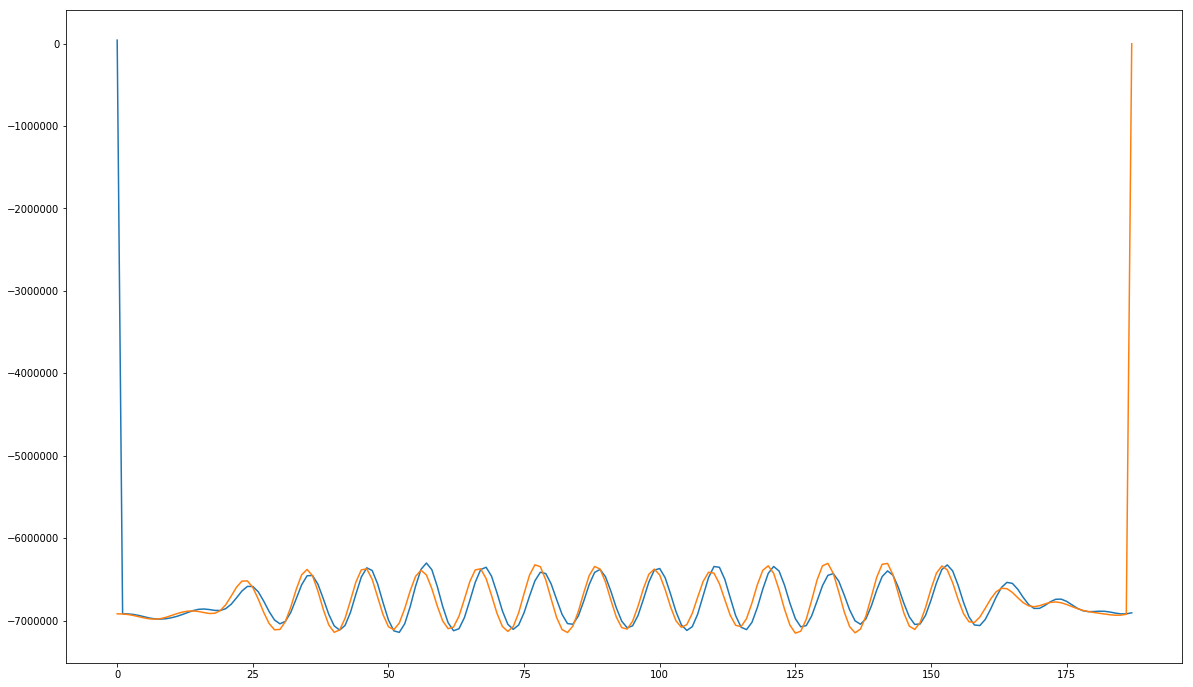

In [102]:
self = fields[1]
def Xrefine_linelocs_pilot(self, linelocs = None):
    if linelocs is None:
        linelocs = self.linelocs[1].copy()
    else:
        linelocs = linelocs.copy()

    for l in range(len(linelocs)):
        pilot = self.data[0]['demod'][int(linelocs[l]-self.usectoinpx(4.7)):int(linelocs[l])].copy()
        pilot -= self.data[0]['demod_05'][int(linelocs[l]-self.usectoinpx(4.7))+32:int(linelocs[l])+32]
        pilot = np.flip(pilot)

        adjfreq = self.rf.freq
        if l > 1:
            adjfreq /= (linelocs[l] - linelocs[l - 1]) / self.rf.inlinelen

        i = 0

        offset = 0
        offsetc = 0

        while i < len(pilot):
            if inrange(pilot[i], -300000, -100000):
                zc = calczc(pilot, i, 0)

                if zc is not None:
                    zcp = zc / (adjfreq / 3.75)
                    print(i, pilot[i], zc, zcp, np.round(zcp) - zcp)

                    offset += np.round(zcp) - zcp
                    offsetc += 1

                    i = np.int(zc + 1)

            i += 1

        if offsetc:
            print(l, offset / offsetc, (offset / offsetc) * (self.rf.freq / 3.75) * 25)
            linelocs[l] += (offset / offsetc) * (self.rf.freq / 3.75) * .25

    return linelocs

f0a = Xrefine_linelocs_pilot(fields[0])
f1a = Xrefine_linelocs_pilot(fields[1]) 
f0b = Xrefine_linelocs_pilot(fields[0], f0a)
f1b = Xrefine_linelocs_pilot(fields[1], f1a) 

plt.plot(fields[0].data[0]['demod'][int(f0b[21]-188):int(f0b[21]+0)])
plt.plot(fields[1].data[0]['demod'][int(f1b[21]-188):int(f1b[21]+0)])

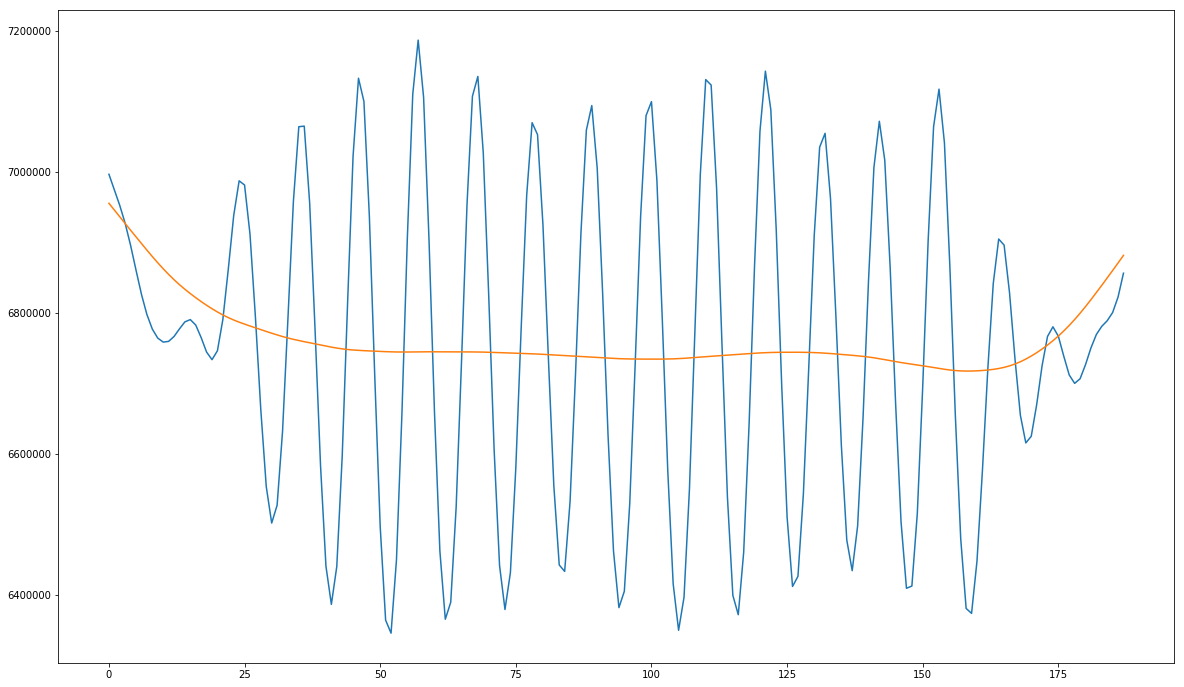

In [101]:
plt.plot(fields[0].data[0]['demod'][int(f0b[21]-188):int(f0b[21]+0)])
plt.plot(fields[0].data[0]['demod_05'][int(f0b[21]-188+32):int(f0b[21]+32)])
#plt.plot(fields[1].data[0]['demod'][int(f1b[21]-188):int(f1b[21]+0)])b

In [100]:
self.data[0]['demod_pilot'][int(linelocs[l]-self.usectoinpx(4.7)):int(linelocs[l])]

NameError: name 'linelocs' is not defined

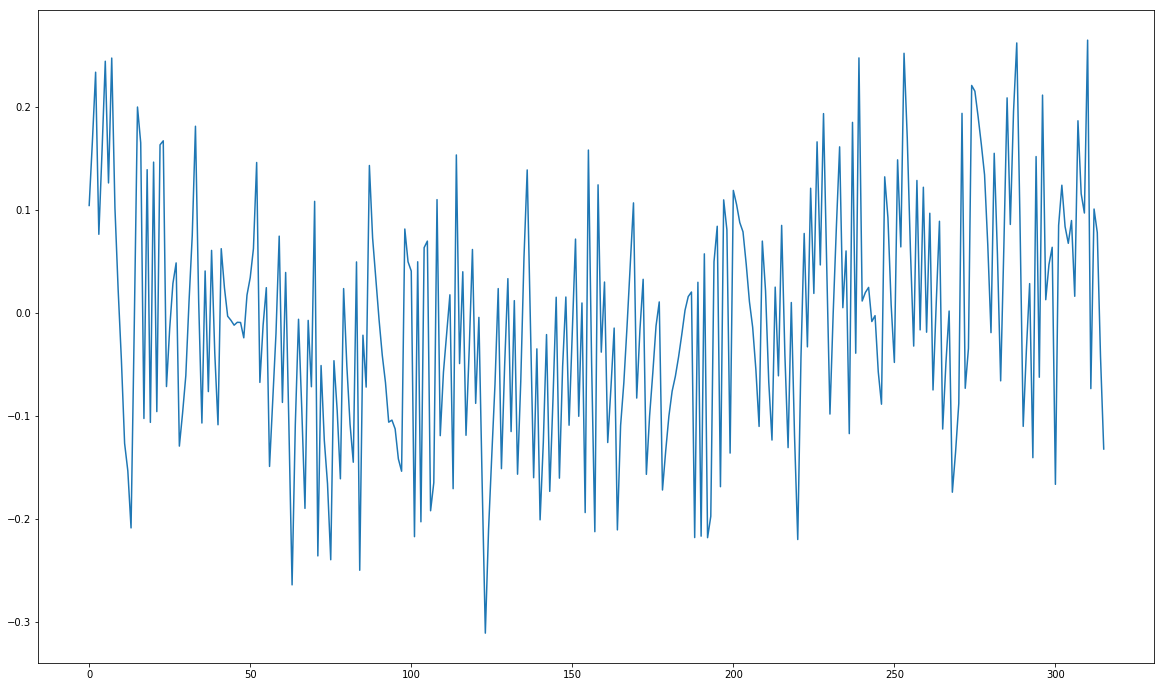

In [94]:
plt.plot(np.array(f0a) - np.array(fields[0].linelocs[1]))

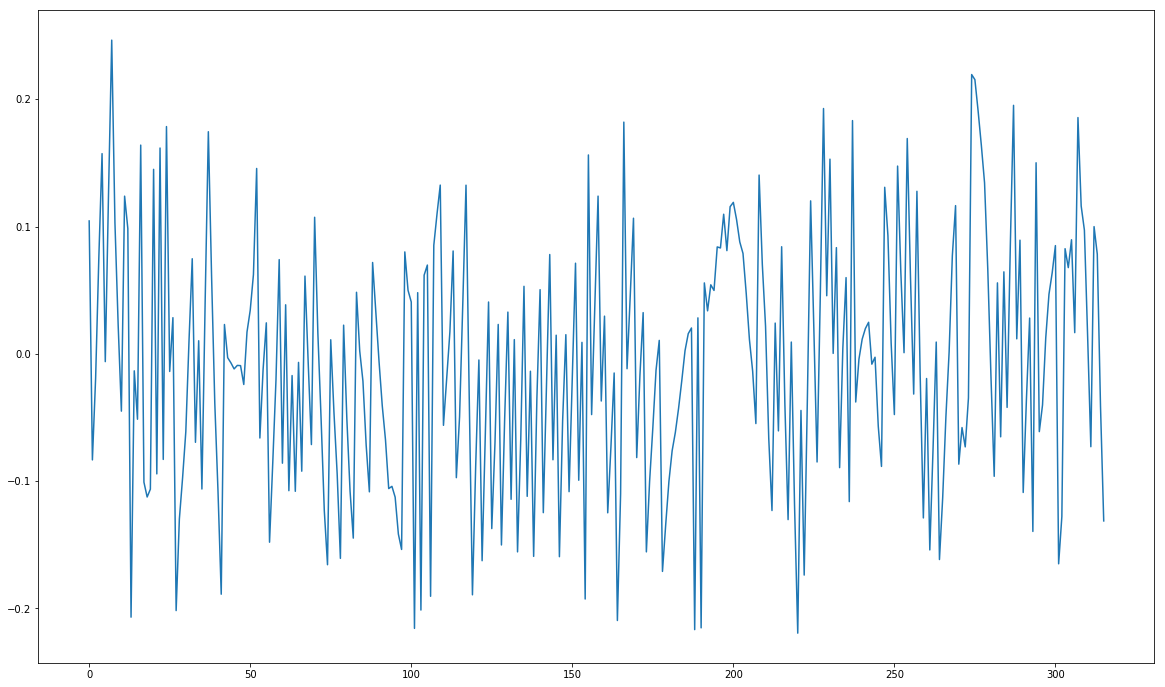

In [96]:
plt.plot(np.array(f0b) - np.array(f0a))

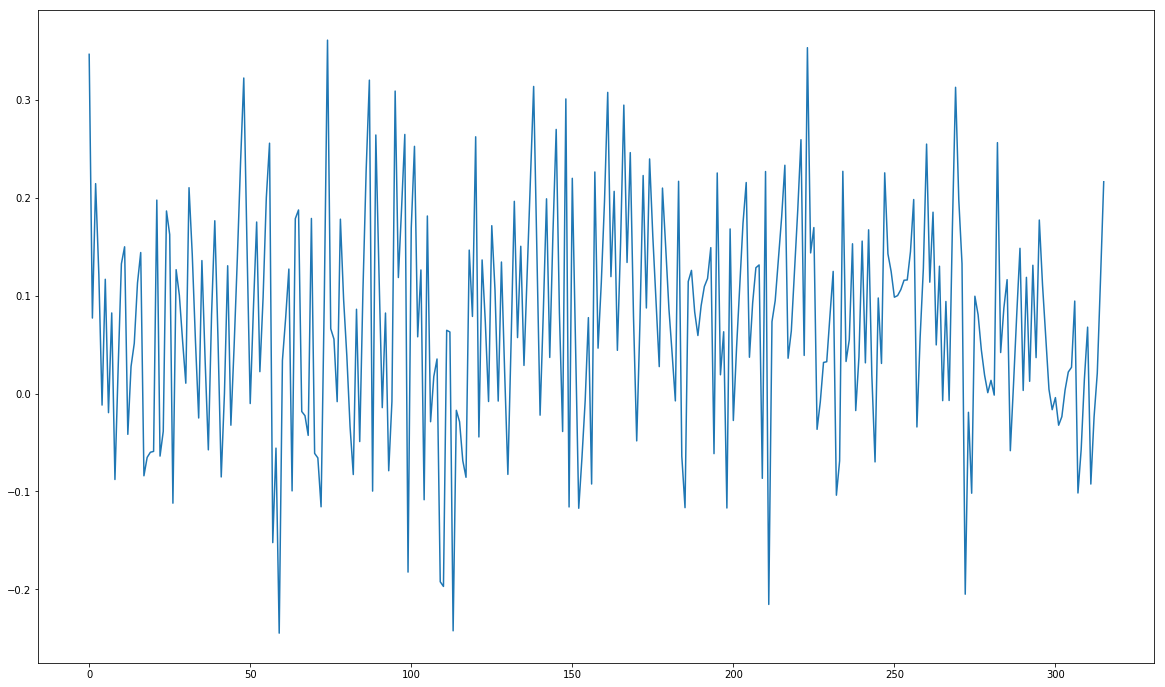

In [95]:
plt.plot(np.array(f1a) - np.array(fields[1].linelocs[1]))

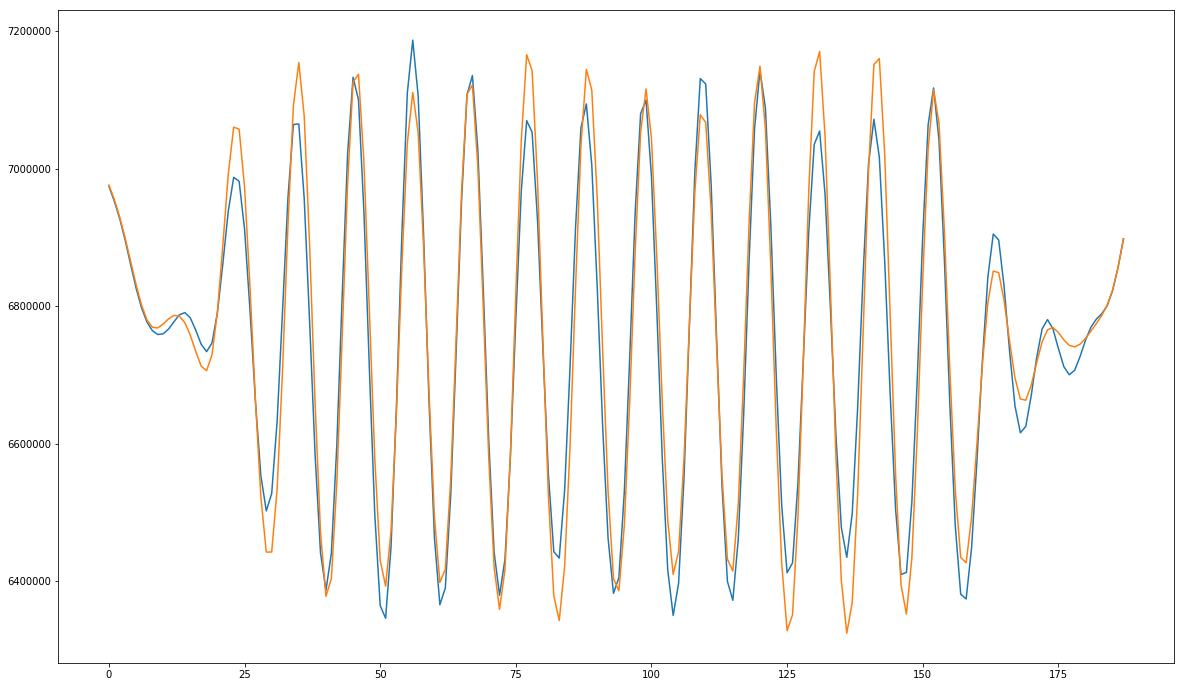

In [85]:
plt.plot(fields[0].data[0]['demod'][int(f0a[21]-188):int(f0a[21]+0)])
plt.plot(fields[1].data[0]['demod'][int(f1a[21]-188):int(f1a[21]+0)])

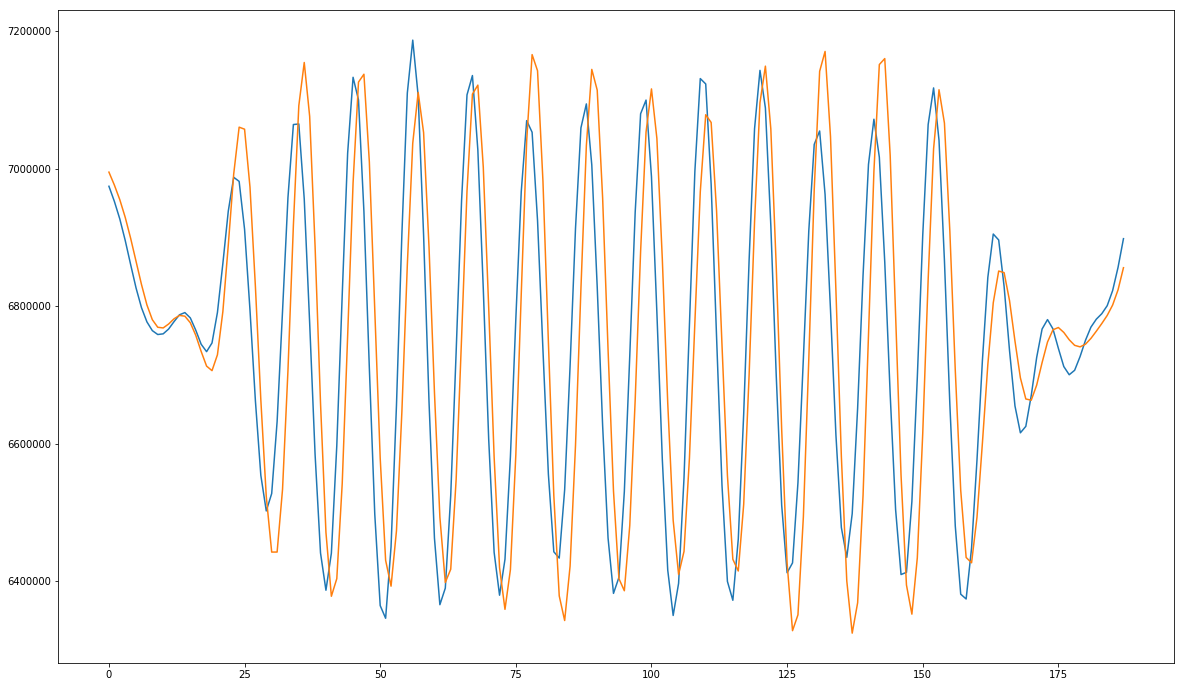

In [81]:
f0 = fields[0].linelocs[1]
f1 = fields[1].linelocs[1]
plt.plot(fields[0].data[0]['demod'][int(f0[21]-188):int(f0[21]+0)])
plt.plot(fields[1].data[0]['demod'][int(f1[21]-188):int(f1[21]+0)])

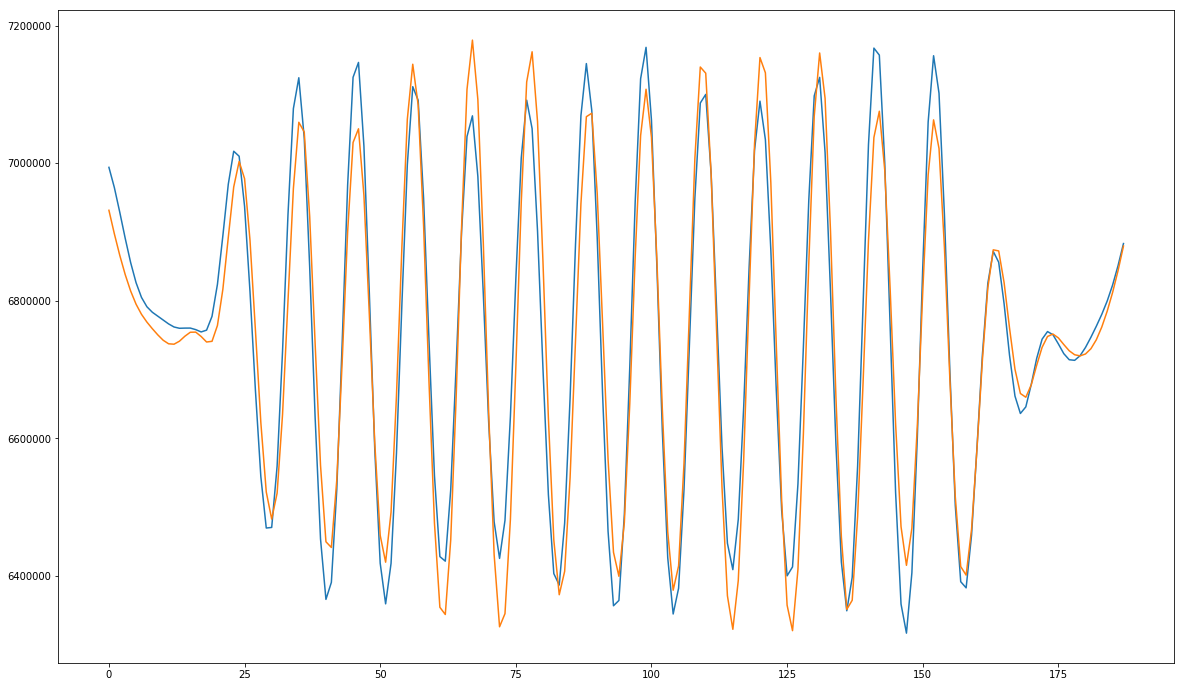

In [55]:
plt.plot(fields[0].data[0]['demod'][int(f0[21]-188):int(f0[21]+0)])
plt.plot(fields[0].data[0]['demod'][int(f0[22]-188):int(f0[22]+0)])
#plt.plot(fields[1].data[0]['demod'][int(f1[21]-188):int(f1[21]+0)])

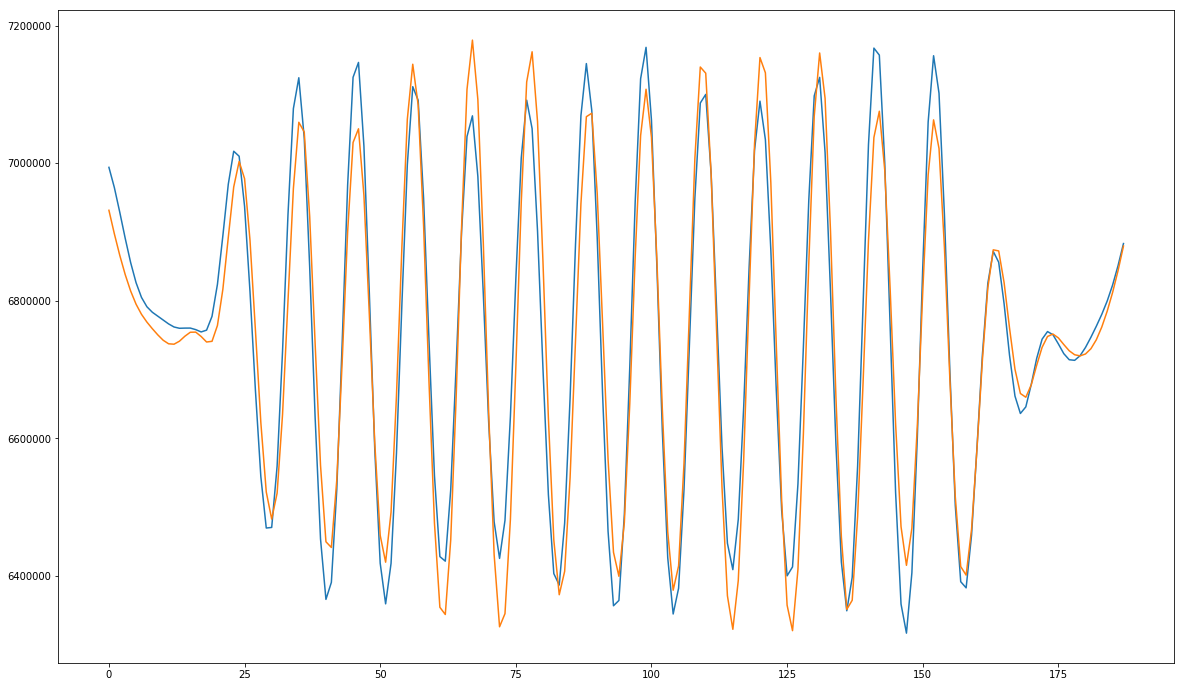

In [48]:
plt.plot(fields[0].data[0]['demod'][int(f0[21]-188):int(f0[21]+0)])
plt.plot(fields[0].data[0]['demod'][int(f0[22]-188):int(f0[22]+0)])

In [ ]:
fields[0].__dict__

In [ ]:
for z in zip(fields[0].linelocs[1], Xrefine_linelocs_pilot(fields[0])):
    print(z)

(354120,)
uint8 (312, 1135) (312, 1135)


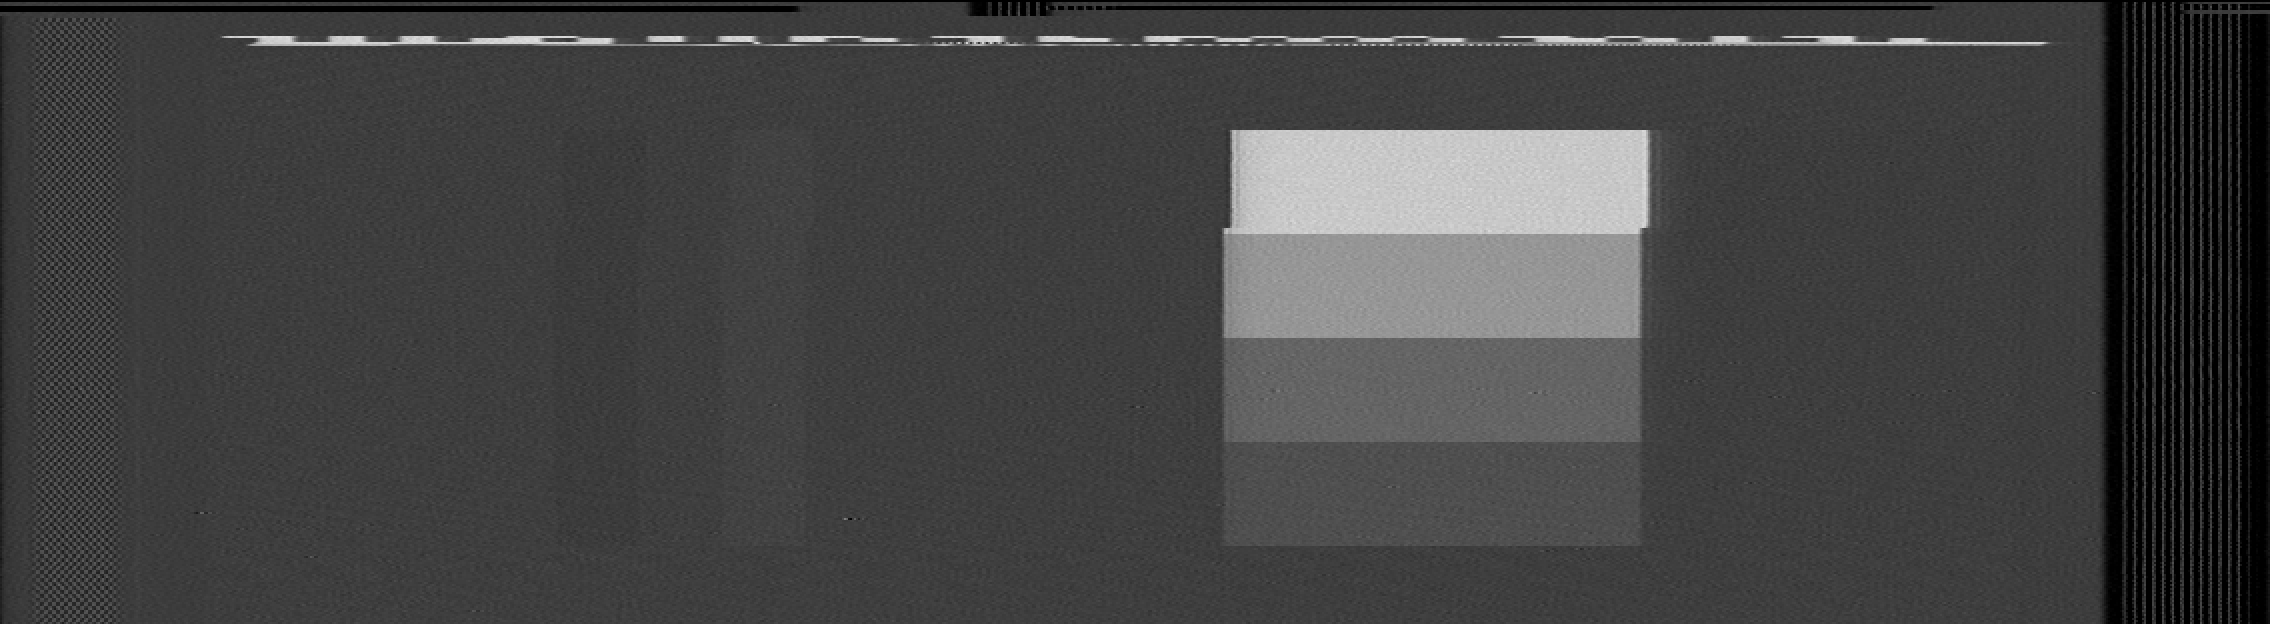

In [60]:
ds0 = fields[0].downscale(lineinfo=f0, final=True)[0]
draw_raw_bwimage(ds0, fields[0].rf.SysParams['outlinelen'], fields[0].linecount, hscale=2, vscale=2)

(354120,)
uint8 (312, 1135) (312, 1135)


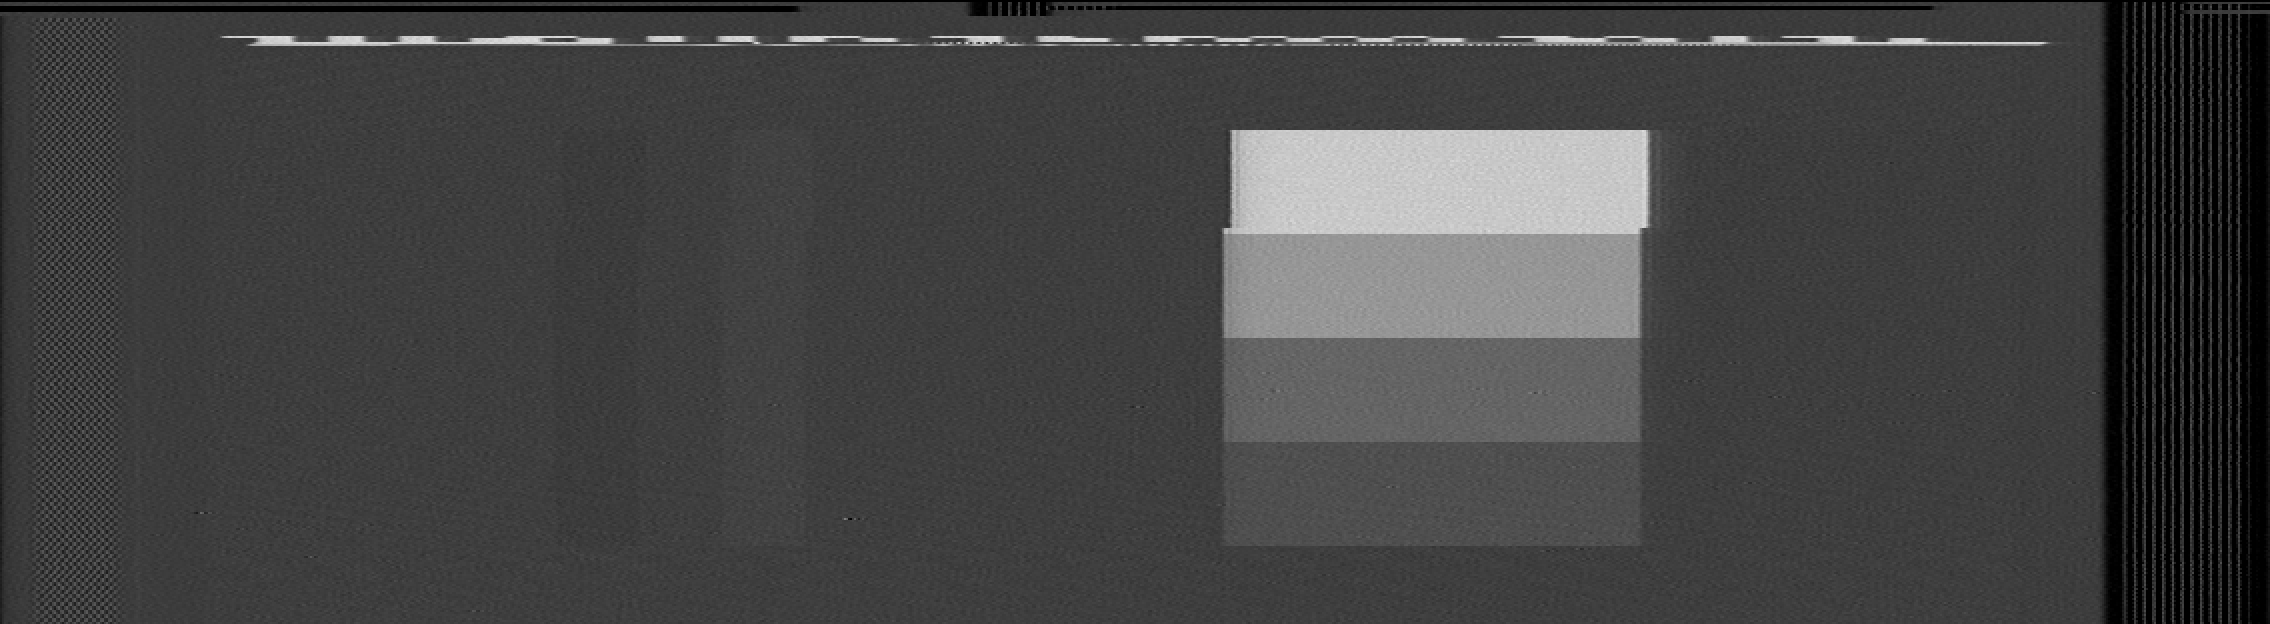

In [62]:
ds0 = fields[0].downscale(lineinfo=fields[0].linelocs[1], final=True)[0]
draw_raw_bwimage(ds0, fields[0].rf.SysParams['outlinelen'], fields[0].linecount, hscale=2, vscale=2)

In [ ]:
ds1 = fields[1].downscale(final=True)[0]
draw_raw_bwimage(ds1, fields[1].rf.SysParams['outlinelen'], fields[1].linecount, hscale=2, vscale=2)

In [ ]:
fields[1].rf.SysParams['outlinelen']

In [ ]:
plt.plot(ds0[(1135*50)+1000:1135*51])
plt.plot(ds1[(1135*50)+1000:1135*51])

In [ ]:
rf_pal

In [ ]:
a = np.concatenate(allaudio)

In [ ]:
len(allaudio[1])

In [ ]:
1921*25

In [ ]:
plt.plot(a[1::2])

In [ ]:
len(audio)//4